# Machine Learning Fundamentals - Lecture 09

This is the Jupyter notebook for Lecture 09 of the Machine Learning Fundamentals
course.

In [110]:
# Import the required libraries using the commonly use short names (pd, sns, ...)
import pandas as pd
import numpy as np

# The Path object from pathlib allows us to easily build paths in an
# OS-independent fashion
from pathlib import Path
import textwrap

# Load the required scikit-learn classes and functions
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nicer style for Seaborn plots
sns.set_style("darkgrid")

## Load dataset and perform initial assessment

We'll start by loading the dataset, and take a look at what information is
contained there.

In [111]:
# Load the dataset (note the use of the Path object)
df = pd.read_csv(Path("..", "datasets", "data_640_validated.csv"), index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640 entries, 598 to 640
Data columns (total 95 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    640 non-null    object
 1   A1_1    640 non-null    object
 2   A1_2    640 non-null    object
 3   A2      640 non-null    object
 4   A3      640 non-null    object
 5   A4      554 non-null    object
 6   A5      640 non-null    object
 7   A6      640 non-null    object
 8   A7      640 non-null    object
 9   A8      640 non-null    object
 10  B1      640 non-null    object
 11  B2      640 non-null    object
 12  B3      640 non-null    object
 13  C1      640 non-null    int64 
 14  C2      640 non-null    int64 
 15  C3      640 non-null    int64 
 16  C4      640 non-null    int64 
 17  C5      640 non-null    int64 
 18  C6      640 non-null    int64 
 19  C7      640 non-null    int64 
 20  C8      640 non-null    int64 
 21  C9      640 non-null    int64 
 22  C10     640 non-null    int64

The dataset has many categorical / free text features. As a first approach,
we'll use the numerical features only. After that, we'll repeat the clustering
analysis with some of the categorial and/or textual features included.

## Clustering analysis using only the numerical features

In [112]:
# Keep only the numerical features
df_num = df.select_dtypes(include="number")

In [113]:
# See standard descriptive statistics about each column
# - The T property allows us to see the dataframe transposed, which is more
# useful when we have a large number of features, which is the case here
df_num.describe().T

count      mean       std  min  25%  50%  75%  max
C1   640.0  3.784375  0.941350  1.0  3.0  4.0  4.0  5.0
C2   640.0  2.987500  1.076059  1.0  2.0  3.0  4.0  5.0
C3   640.0  4.100000  0.869947  1.0  4.0  4.0  5.0  5.0
C4   640.0  2.700000  1.049927  1.0  2.0  3.0  3.0  5.0
C5   640.0  4.334375  0.858032  1.0  4.0  5.0  5.0  5.0
..     ...       ...       ...  ...  ...  ...  ...  ...
F28  640.0  3.987500  0.988114  1.0  3.0  4.0  5.0  5.0
F29  640.0  2.035938  1.120427  1.0  1.0  2.0  3.0  5.0
F30  640.0  3.909375  1.063510  1.0  3.0  4.0  5.0  5.0
F31  640.0  3.100000  1.359831  1.0  2.0  3.0  4.0  5.0
F32  640.0  2.178125  1.270647  1.0  1.0  2.0  3.0  5.0

[75 rows x 8 columns]

These numerical features are all between 1 and 5, and correspond to
questionnaire answers. Although not strictly necessary here because all features
have the same dimensions, let's standard scale them:

In [114]:
X_num_scaled = StandardScaler().fit_transform(df_num)

### Choosing the number of clusters

Let's proceed with clustering and finding the most appropriate number of
clusters.

In [115]:
# We'll put results in this list
clust_results_num = []

# Generate 30 uncorrelated random seeds for running k-means 30 times
seeds = np.random.default_rng(123).integers(0, 9999999, 30)

# Loop through k
for k in range(2,11):

    # Loop through seeds
    for seed in seeds:

        # Perform k-means for the current k and seed combination
        km = KMeans(n_clusters=k, random_state=seed)
        clu_lbls = km.fit_predict(X_num_scaled)

        # Get the silhouette score and save it to the results list
        ss = silhouette_score(X_num_scaled, clu_lbls)
        clust_results_num.append([k, seed, ss])

# Create the results data frame and show it
df_results_num = pd.DataFrame(clust_results_num, columns=["k", "seed", "ss"])

df_results_num

k     seed        ss
0     2   154405  0.162724
1     2  6823517  0.163004
2     2  5929477  0.163004
3     2   538210  0.163004
4     2  9090867  0.162724
..   ..      ...       ...
265  10  8242415  0.052244
266  10  7920811  0.054844
267  10  2137629  0.057753
268  10  4096017  0.051518
269  10  7414669  0.054898

[270 rows x 3 columns]

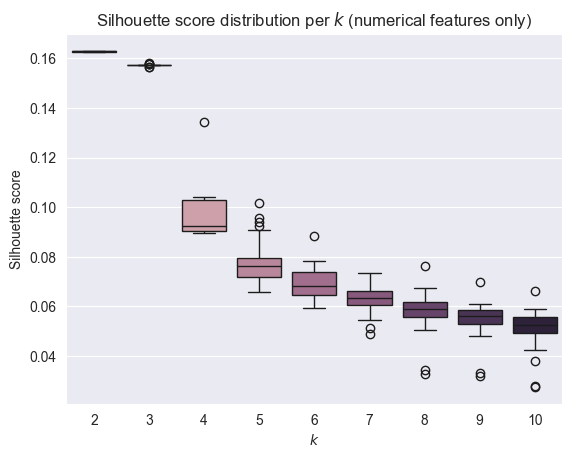

In [116]:
# See the silhouette score distribution per k
ax = sns.boxplot(df_results_num, x="k", y="ss", hue="k", legend=False)
ax.set_xlabel("$k$")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette score distribution per $k$ (numerical features only)");

It appears that $k=2$ is the ideal number of clusters. Let's filter our results
and get a top 5 ranking of best seeds for $k=2$.

In [117]:
df_results_num[df_results_num["k"] == 2].sort_values(by="ss", ascending=False).head(5)

k     seed        ss
1   2  6823517  0.163004
2   2  5929477  0.163004
5   2  2203598  0.163004
3   2   538210  0.163004
11  2  8120944  0.163004

Not much variation for $k=2$, which is also clear by looking at the box plot
above.

Let's repeat clustering with $k=2$ for one of the top seeds, apply PCA and then
plot the two first principal components (PC1 and PC2).

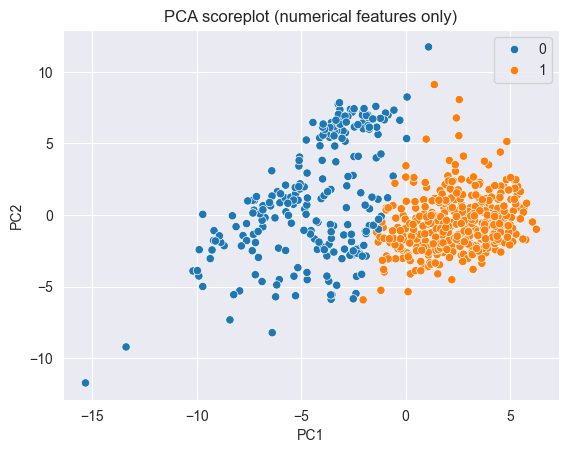

In [118]:
# Perform k-means with the top seed
km_num = KMeans(n_clusters=2, random_state=6823517)
clust_labels_num = km_num.fit_predict(X_num_scaled)

# Apply PCA and get the first two principal components (PCs)
pca_num = PCA(n_components=2)
X_pca_num = pca_num.fit_transform(X_num_scaled)

# Display scatter plot of the first two PCs
ax = sns.scatterplot(x=X_pca_num[:,0], y=X_pca_num[:,1], hue=clust_labels_num)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA scoreplot (numerical features only)");

The score plot more or less confirms the results provided by the Silhouette
score: at lest two clusters are visible, and it's not unfeasible that cluster 0
(the blue one) can be itself divided into two clusters. Let's consider more
features and perform a more thorough analysis.

## Including additional categorial / textual features

In this section we'll try and use more features by converting categorical and/or
non-numerical features into numerical ones.

First, we'll load the features description file, to help us keep in mind what
is actually represented by each feature.

In [119]:
df_feat_info = pd.read_excel(Path("..", "datasets", "data_640_validated_info.xlsx"))

df_feat_info

Code  \
0   A1.1   
1   A1.2   
2     A2   
3     A3   
4     A4   
..   ...   
89   F28   
90   F29   
91   F30   
92   F31   
93   F32   

                                                                                  Question  \
0                                                                What is your nationality?   
1                                                              Region: generated from A1.1   
2                                                             What is your biological sex?   
3                                 What is the highest educational level you have completed   
4                                                  Do you have a pet or  a garden at home?   
..                                                                                     ...   
89     In overall, how do you feel about the game? [I was deeply concentrated in the game]   
90                         In overall, how do you feel about the game? [I felt frustrated]   
91            In overall, how do you feel about the game? [It felt like a rich experience]   
92  In overall, how do you feel about the game? [I lost connection with the outside world]   
93                      In overall, how do you feel about the game? [I felt time pressure]   

                            Group  
0   1. Socio-demographic profiles  
1   1. Socio-demographic profiles  
2   1. Socio-demographic profiles  
3   1. Socio-demographic profiles  
4   1. Socio-demographic profiles  
..                            ...  
89         6.Game-playing feeling  
90         6.Game-playing feeling  
91         6.Game-playing feeling  
92         6.Game-playing feeling  
93         6.Game-playing feeling  

[94 rows x 3 columns]

Let's look at the non-numerical features, ignoring the "Date" column:

In [120]:
df_obj = df.select_dtypes(include="object").drop(columns=["Date"])

df_obj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 640 entries, 598 to 640
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   A1_1    640 non-null    object
 1   A1_2    640 non-null    object
 2   A2      640 non-null    object
 3   A3      640 non-null    object
 4   A4      554 non-null    object
 5   A5      640 non-null    object
 6   A6      640 non-null    object
 7   A7      640 non-null    object
 8   A8      640 non-null    object
 9   B1      640 non-null    object
 10  B2      640 non-null    object
 11  B3      640 non-null    object
 12  D1      634 non-null    object
 13  D2      635 non-null    object
 14  D3      639 non-null    object
 15  D4      639 non-null    object
 16  D5      640 non-null    object
 17  D6      640 non-null    object
 18  D7      627 non-null    object
dtypes: object(19)
memory usage: 100.0+ KB


Looking at those feature codes is not very helpful. Let's associate them with
the actual feature description:

In [121]:
pd.set_option("display.max_colwidth", None)

df_feature_legend = pd.merge(
    left=pd.Series(df_obj.columns, name="Code"), right=df_feat_info, on="Code"
).drop(columns=["Group"])

df_feature_legend

Code  \
0    A2   
1    A3   
2    A4   
3    A5   
4    A6   
5    A7   
6    A8   
7    B1   
8    B2   
9    B3   
10   D1   
11   D2   
12   D3   
13   D4   
14   D5   
15   D6   
16   D7   

                                                                                                               Question  
0                                                                                          What is your biological sex?  
1                                                              What is the highest educational level you have completed  
2                                                                               Do you have a pet or  a garden at home?  
3                                                                                                     What is your age?  
4                                                                                        Please specify your ethnicity.  
5                                                                                          What is your marital status?  
6                                                                                Employment Status: Are you currently…?  
7                                                                   Are you currently self-isolated/ social distancing?  
8   How long have you been self-isolated/ social distancing? (please tick "no", if you are not currently self-isolated)  
9                                                                 How much are you worried about the COVID-19 outbreak?  
10                                                                          How long have you been playing video games?  
11                                                                        Which genre of video games do you often play?  
12                                                                          How often do you play computer/video games?  
13                                    How many hours on average did you spend playing game a day in the last two weeks?  
14                                                                               How often do you play Animal Crossing?  
15                                                                          What is your favorite activity in the game?  
16                                                           Which style/theme do you prefer when you can terraforming?

Much clearer now. In the following subsections we'll analyse each of these
non-numerical features and possibly convert them to numeric in order to use them
in our clustering analysis.

### Convert categorical/textual features into numerical features

We'll be adding the new features to the `df_num_all` dataframe below:

In [122]:
df_num_all = df_num.copy()

#### A2 - Biological sex

In [123]:
df["A2"].unique()

array(['Male', 'Female'], dtype=object)

Although there are only "Male" and "Female" answers, which means we could make
a binary "Gender" feature, it is culturally sensitive and increasingly
unrealistic to assume gender can be represented in a binary fashion. Therefore,
we'll use one-hot encoding.

In [124]:
# One-hot encode the A2 "gender" column
enc = OneHotEncoder(sparse_output=False)

gender_ohe = enc.fit_transform(df[["A2"]])

# Get new column names
gender_new_cols = enc.get_feature_names_out(["A2"])

# Add them directly to the DataFrame
df_num_all[gender_new_cols] = gender_ohe

In [125]:
# Check if the new columns appear at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  F25  F26  F27  F28  F29  \
598   4   3   5   1   5   2   4   3   3    4  ...    5    4    5    4    1   
230   4   2   5   5   5   3   5   5   5    5  ...    4    2    5    4    2   
232   5   2   5   4   5   3   5   5   5    5  ...    4    1    5    3    2   
308   4   4   5   3   4   1   5   4   4    3  ...    3    4    5    5    2   
231   3   4   3   1   5   1   3   4   5    3  ...    4    3    4    4    1   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
356   3   2   3   2   4   2   4   2   4    4  ...    4    3    4    4    2   
416   4   3   4   3   5   3   4   4   4    5  ...    5    3    5    5    1   
502   4   3   4   3   4   2   4   3   5    5  ...    4    4    5    5    1   
549   4   4   4   2   4   4   2   3   4    4  ...    4    3    3    3    3   
640   4   4   3   5   2   2   5   5   4    4  ...    2    3    3    2    1   

     F30  F31  F32  A2_Female  A2_Male  
598    5    1    1        0.0      1.0  
230    4    1    4        0.0      1.0  
232    5    2    4        0.0      1.0  
308    5    1    2        1.0      0.0  
231    5    5    5        0.0      1.0  
..   ...  ...  ...        ...      ...  
356    3    1    1        1.0      0.0  
416    4    5    1        1.0      0.0  
502    5    2    2        1.0      0.0  
549    2    2    3        1.0      0.0  
640    2    1    1        1.0      0.0  

[640 rows x 77 columns]

#### A3 - Highest educational level completed

In [126]:
df["A3"].unique()

array(['Secondary school', 'High school', 'Primary school',
       'Undergraduate school', 'Graduate school and higher'], dtype=object)

There's a natural order to educational level, so let's order it appropriately
and use an ordinal encoder to convert it to numerical. Note that we could've
done this easily "by hand" instead of using `OrdinalEncoder`.

In [127]:
# Proper educational level ordering
education_order = [
    "Primary school",
    "Secondary school",
    "High school",
    "Undergraduate school",
    "Graduate school and higher",
]

# Convert to numerical using an ordinal encoder
encoder = OrdinalEncoder(categories=[education_order])

education_oe = encoder.fit_transform(df[["A3"]])
df_num_all["A3_education"] = education_oe

In [128]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  F26  F27  F28  F29  F30  \
598   4   3   5   1   5   2   4   3   3    4  ...    4    5    4    1    5   
230   4   2   5   5   5   3   5   5   5    5  ...    2    5    4    2    4   
232   5   2   5   4   5   3   5   5   5    5  ...    1    5    3    2    5   
308   4   4   5   3   4   1   5   4   4    3  ...    4    5    5    2    5   
231   3   4   3   1   5   1   3   4   5    3  ...    3    4    4    1    5   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
356   3   2   3   2   4   2   4   2   4    4  ...    3    4    4    2    3   
416   4   3   4   3   5   3   4   4   4    5  ...    3    5    5    1    4   
502   4   3   4   3   4   2   4   3   5    5  ...    4    5    5    1    5   
549   4   4   4   2   4   4   2   3   4    4  ...    3    3    3    3    2   
640   4   4   3   5   2   2   5   5   4    4  ...    3    3    2    1    2   

     F31  F32  A2_Female  A2_Male  A3_education  
598    1    1        0.0      1.0           1.0  
230    1    4        0.0      1.0           1.0  
232    2    4        0.0      1.0           1.0  
308    1    2        1.0      0.0           2.0  
231    5    5        0.0      1.0           1.0  
..   ...  ...        ...      ...           ...  
356    1    1        1.0      0.0           4.0  
416    5    1        1.0      0.0           3.0  
502    2    2        1.0      0.0           3.0  
549    2    3        1.0      0.0           3.0  
640    1    1        1.0      0.0           3.0  

[640 rows x 78 columns]

#### A4 - Pet or a garden at home?

In [129]:
df["A4"].unique()

array(['A pet', 'Both', 'A garden', nan], dtype=object)

Given the way this column is coded, the easiest way to convert this to numerical
is to create two new columns: one for having a pet, the other for having a
garden. We'll populate these new columns "by hand" using basic Python code:

In [130]:
df_num_all["A4_pet"] = df["A4"].isin(["A pet", "Both"]).astype(int)
df_num_all["A4_garden"] = df["A4"].isin(["A garden", "Both"]).astype(int)

In [131]:
# Check if the new columns appear at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  F28  F29  F30  F31  F32  \
598   4   3   5   1   5   2   4   3   3    4  ...    4    1    5    1    1   
230   4   2   5   5   5   3   5   5   5    5  ...    4    2    4    1    4   
232   5   2   5   4   5   3   5   5   5    5  ...    3    2    5    2    4   
308   4   4   5   3   4   1   5   4   4    3  ...    5    2    5    1    2   
231   3   4   3   1   5   1   3   4   5    3  ...    4    1    5    5    5   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
356   3   2   3   2   4   2   4   2   4    4  ...    4    2    3    1    1   
416   4   3   4   3   5   3   4   4   4    5  ...    5    1    4    5    1   
502   4   3   4   3   4   2   4   3   5    5  ...    5    1    5    2    2   
549   4   4   4   2   4   4   2   3   4    4  ...    3    3    2    2    3   
640   4   4   3   5   2   2   5   5   4    4  ...    2    1    2    1    1   

     A2_Female  A2_Male  A3_education  A4_pet  A4_garden  
598        0.0      1.0           1.0       1          0  
230        0.0      1.0           1.0       1          1  
232        0.0      1.0           1.0       1          1  
308        1.0      0.0           2.0       1          0  
231        0.0      1.0           1.0       1          0  
..         ...      ...           ...     ...        ...  
356        1.0      0.0           4.0       1          1  
416        1.0      0.0           3.0       1          0  
502        1.0      0.0           3.0       1          0  
549        1.0      0.0           3.0       1          1  
640        1.0      0.0           3.0       0          0  

[640 rows x 80 columns]

#### A5 - Age

In [132]:
df["A5"].unique()

array(['11', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '45',
       '46', '48', '49', '55', '30s', 'sub 28'], dtype=object)

There are some weird non-quite-numerical values in there, so let's convert
those to numeric, making some assumptions (i.e., guesswork):

In [133]:
df.loc[df["A5"] == "30s", "A5"] = "35"
df.loc[df["A5"] == "sub 28", "A5"] = "22"

Now we can directly convert the column to numeric in the new dataframe:

In [134]:
df_num_all["A5_age"] = df["A5"].astype(int)

In [135]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  F29  F30  F31  F32  \
598   4   3   5   1   5   2   4   3   3    4  ...    1    5    1    1   
230   4   2   5   5   5   3   5   5   5    5  ...    2    4    1    4   
232   5   2   5   4   5   3   5   5   5    5  ...    2    5    2    4   
308   4   4   5   3   4   1   5   4   4    3  ...    2    5    1    2   
231   3   4   3   1   5   1   3   4   5    3  ...    1    5    5    5   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...   
356   3   2   3   2   4   2   4   2   4    4  ...    2    3    1    1   
416   4   3   4   3   5   3   4   4   4    5  ...    1    4    5    1   
502   4   3   4   3   4   2   4   3   5    5  ...    1    5    2    2   
549   4   4   4   2   4   4   2   3   4    4  ...    3    2    2    3   
640   4   4   3   5   2   2   5   5   4    4  ...    1    2    1    1   

     A2_Female  A2_Male  A3_education  A4_pet  A4_garden  A5_age  
598        0.0      1.0           1.0       1          0      11  
230        0.0      1.0           1.0       1          1      13  
232        0.0      1.0           1.0       1          1      13  
308        1.0      0.0           2.0       1          0      13  
231        0.0      1.0           1.0       1          0      14  
..         ...      ...           ...     ...        ...     ...  
356        1.0      0.0           4.0       1          1      48  
416        1.0      0.0           3.0       1          0      49  
502        1.0      0.0           3.0       1          0      55  
549        1.0      0.0           3.0       1          1      35  
640        1.0      0.0           3.0       0          0      22  

[640 rows x 81 columns]

#### A6 - Ethnicity

In [136]:
df["A6"].unique()

array(['Asian', 'White', 'Hispanic or Latino', 'Other',
       'Pacific Islander', 'Black or African American',
       'Native American or American Indian'], dtype=object)

We'll ignore this one. It'll create a lot of new one-hot encoded features, and
the gains in terms of clustering might not be that clear.

#### A7 - Marital status

In [137]:
df["A7"].unique()

array(['Single, never married', 'Married or domestic partnership',
       'Separated', 'Divorced', 'Widowed'], dtype=object)

We'll just consider "single" and "living with someone", e.g., let's convert it
to a binary feature.

In [138]:
df_num_all["A7_relationship"] = (df["A7"] == "Married or domestic partnership").astype(int)

In [139]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  F30  F31  F32  A2_Female  \
598   4   3   5   1   5   2   4   3   3    4  ...    5    1    1        0.0   
230   4   2   5   5   5   3   5   5   5    5  ...    4    1    4        0.0   
232   5   2   5   4   5   3   5   5   5    5  ...    5    2    4        0.0   
308   4   4   5   3   4   1   5   4   4    3  ...    5    1    2        1.0   
231   3   4   3   1   5   1   3   4   5    3  ...    5    5    5        0.0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...        ...   
356   3   2   3   2   4   2   4   2   4    4  ...    3    1    1        1.0   
416   4   3   4   3   5   3   4   4   4    5  ...    4    5    1        1.0   
502   4   3   4   3   4   2   4   3   5    5  ...    5    2    2        1.0   
549   4   4   4   2   4   4   2   3   4    4  ...    2    2    3        1.0   
640   4   4   3   5   2   2   5   5   4    4  ...    2    1    1        1.0   

     A2_Male  A3_education  A4_pet  A4_garden  A5_age  A7_relationship  
598      1.0           1.0       1          0      11                0  
230      1.0           1.0       1          1      13                0  
232      1.0           1.0       1          1      13                0  
308      0.0           2.0       1          0      13                0  
231      1.0           1.0       1          0      14                0  
..       ...           ...     ...        ...     ...              ...  
356      0.0           4.0       1          1      48                1  
416      0.0           3.0       1          0      49                0  
502      0.0           3.0       1          0      55                1  
549      0.0           3.0       1          1      35                1  
640      0.0           3.0       0          0      22                0  

[640 rows x 82 columns]

#### A8 - Employment Status

In [140]:
df["A8"].unique()

array(['A student', 'Out of work and looking for work', 'Unable to work',
       'Employed for wages', 'Retired',
       'Out of work but not currently looking for work', 'Military',
       'Self-employed', 'A homemaker'], dtype=object)

We'll also ignore this one. It would create a lot of new one-hot encoded
features, and it's not trivial how it could be simplified in the way we did with
the marital status.

In any case, this feature might have some relevance in the forming of clusters.

#### B1 - Social distancing

In [141]:
df["B1"].unique()

array(['Yes', 'No'], dtype=object)

Easy to keep, let's just convert it into a binary feature.

In [142]:
df_num_all["B1_social_dist"] = (df["B1"] == "Yes").astype(int)

In [143]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  F31  F32  A2_Female  \
598   4   3   5   1   5   2   4   3   3    4  ...    1    1        0.0   
230   4   2   5   5   5   3   5   5   5    5  ...    1    4        0.0   
232   5   2   5   4   5   3   5   5   5    5  ...    2    4        0.0   
308   4   4   5   3   4   1   5   4   4    3  ...    1    2        1.0   
231   3   4   3   1   5   1   3   4   5    3  ...    5    5        0.0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...        ...   
356   3   2   3   2   4   2   4   2   4    4  ...    1    1        1.0   
416   4   3   4   3   5   3   4   4   4    5  ...    5    1        1.0   
502   4   3   4   3   4   2   4   3   5    5  ...    2    2        1.0   
549   4   4   4   2   4   4   2   3   4    4  ...    2    3        1.0   
640   4   4   3   5   2   2   5   5   4    4  ...    1    1        1.0   

     A2_Male  A3_education  A4_pet  A4_garden  A5_age  A7_relationship  \
598      1.0           1.0       1          0      11                0   
230      1.0           1.0       1          1      13                0   
232      1.0           1.0       1          1      13                0   
308      0.0           2.0       1          0      13                0   
231      1.0           1.0       1          0      14                0   
..       ...           ...     ...        ...     ...              ...   
356      0.0           4.0       1          1      48                1   
416      0.0           3.0       1          0      49                0   
502      0.0           3.0       1          0      55                1   
549      0.0           3.0       1          1      35                1   
640      0.0           3.0       0          0      22                0   

     B1_social_dist  
598               1  
230               1  
232               1  
308               1  
231               1  
..              ...  
356               1  
416               1  
502               1  
549               1  
640               0  

[640 rows x 83 columns]

#### B2 - How long in social distancing

In [144]:
df["B2"].unique()

array(['More than a month', 'More than 3 weeks',
       'No self-isolation/social distancing', 'More than 2 weeks',
       'More than a week', '1 day', '5 days', '3 days', '6 days',
       '4 days', '7 days'], dtype=object)

We'll use this as an numerical feature measured in days. However, we need to
make some assumptions regarding those "More than..." categories.

In [145]:
conv_days_social_dist = {
    "No self-isolation/social distancing": 0,
    "1 day": 1,
    "3 days": 3,
    "4 days": 3,
    "5 days": 5,
    "6 days": 6,
    "7 days": 7,
    "More than a week": 10,  # Assume more than a week is about 10 days
    "More than 2 weeks": 18, # Assume more than two weeks is about 18 days
    "More than 3 weeks": 26, # Assume more than three weeks is about 26 days
    "More than a month": 45, # Assume more than a month is about 45 days
}

df_num_all["B2_social_dist_days"] = df["B2"].map(conv_days_social_dist)

In [146]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  F32  A2_Female  A2_Male  \
598   4   3   5   1   5   2   4   3   3    4  ...    1        0.0      1.0   
230   4   2   5   5   5   3   5   5   5    5  ...    4        0.0      1.0   
232   5   2   5   4   5   3   5   5   5    5  ...    4        0.0      1.0   
308   4   4   5   3   4   1   5   4   4    3  ...    2        1.0      0.0   
231   3   4   3   1   5   1   3   4   5    3  ...    5        0.0      1.0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...        ...      ...   
356   3   2   3   2   4   2   4   2   4    4  ...    1        1.0      0.0   
416   4   3   4   3   5   3   4   4   4    5  ...    1        1.0      0.0   
502   4   3   4   3   4   2   4   3   5    5  ...    2        1.0      0.0   
549   4   4   4   2   4   4   2   3   4    4  ...    3        1.0      0.0   
640   4   4   3   5   2   2   5   5   4    4  ...    1        1.0      0.0   

     A3_education  A4_pet  A4_garden  A5_age  A7_relationship  B1_social_dist  \
598           1.0       1          0      11                0               1   
230           1.0       1          1      13                0               1   
232           1.0       1          1      13                0               1   
308           2.0       1          0      13                0               1   
231           1.0       1          0      14                0               1   
..            ...     ...        ...     ...              ...             ...   
356           4.0       1          1      48                1               1   
416           3.0       1          0      49                0               1   
502           3.0       1          0      55                1               1   
549           3.0       1          1      35                1               1   
640           3.0       0          0      22                0               0   

     B2_social_dist_days  
598                   45  
230                   45  
232                   45  
308                   45  
231                   26  
..                   ...  
356                   45  
416                   45  
502                   45  
549                   45  
640                    0  

[640 rows x 84 columns]

#### B3 - Worried about COVID-19

In [147]:
df["B3"].unique()

array(['Worried', 'A little', 'Very worried', 'Not at all'], dtype=object)

Clearly an ordinal feature. Let's order it and use `OrdinalEncoder`:

In [148]:
worried_order = [
    "Not at all",
    "A little",
    "Worried",
    "Very worried",
]

encoder = OrdinalEncoder(categories=[worried_order])

worried_oe = encoder.fit_transform(df[["B3"]])
df_num_all["B3_covid_worried"] = worried_oe

In [149]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  A2_Female  A2_Male  \
598   4   3   5   1   5   2   4   3   3    4  ...        0.0      1.0   
230   4   2   5   5   5   3   5   5   5    5  ...        0.0      1.0   
232   5   2   5   4   5   3   5   5   5    5  ...        0.0      1.0   
308   4   4   5   3   4   1   5   4   4    3  ...        1.0      0.0   
231   3   4   3   1   5   1   3   4   5    3  ...        0.0      1.0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...        ...      ...   
356   3   2   3   2   4   2   4   2   4    4  ...        1.0      0.0   
416   4   3   4   3   5   3   4   4   4    5  ...        1.0      0.0   
502   4   3   4   3   4   2   4   3   5    5  ...        1.0      0.0   
549   4   4   4   2   4   4   2   3   4    4  ...        1.0      0.0   
640   4   4   3   5   2   2   5   5   4    4  ...        1.0      0.0   

     A3_education  A4_pet  A4_garden  A5_age  A7_relationship  B1_social_dist  \
598           1.0       1          0      11                0               1   
230           1.0       1          1      13                0               1   
232           1.0       1          1      13                0               1   
308           2.0       1          0      13                0               1   
231           1.0       1          0      14                0               1   
..            ...     ...        ...     ...              ...             ...   
356           4.0       1          1      48                1               1   
416           3.0       1          0      49                0               1   
502           3.0       1          0      55                1               1   
549           3.0       1          1      35                1               1   
640           3.0       0          0      22                0               0   

     B2_social_dist_days  B3_covid_worried  
598                   45               2.0  
230                   45               2.0  
232                   45               1.0  
308                   45               2.0  
231                   26               1.0  
..                   ...               ...  
356                   45               3.0  
416                   45               2.0  
502                   45               2.0  
549                   45               1.0  
640                    0               2.0  

[640 rows x 85 columns]

#### D1 - How long playing video games

In [150]:
df["D1"].unique()

array(['More than 3 years', '1-2 years', '2-3 years', '0-1 years', nan],
      dtype=object)

This can be look at as a numerical feature (in years) or an ordinal one. Also,
we need to do something about the `nan` values. Here, I'll make the empirical
decision of considering the feature ordinal and placing `nan` values in the
middle of the ordering, effectively replacing missing values with the average
of other features. Might not be the best approach, but it's a quick one for the
intended purposes.

In [151]:
playing_games_order = [
    "0-1 years",
    "1-2 years",
    "nan", # cheating a bit, we'll consider "nan" to be in the middle of the others
    "2-3 years",
    "More than 3 years",
]

df_d1 = pd.DataFrame(df["D1"].fillna("nan"), columns=["D1"])

encoder = OrdinalEncoder(categories=[playing_games_order])

yplaygames_oe = encoder.fit_transform(df_d1[["D1"]])
df_num_all["D1_years_playing_games"] = yplaygames_oe

In [152]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  A2_Male  A3_education  \
598   4   3   5   1   5   2   4   3   3    4  ...      1.0           1.0   
230   4   2   5   5   5   3   5   5   5    5  ...      1.0           1.0   
232   5   2   5   4   5   3   5   5   5    5  ...      1.0           1.0   
308   4   4   5   3   4   1   5   4   4    3  ...      0.0           2.0   
231   3   4   3   1   5   1   3   4   5    3  ...      1.0           1.0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...      ...           ...   
356   3   2   3   2   4   2   4   2   4    4  ...      0.0           4.0   
416   4   3   4   3   5   3   4   4   4    5  ...      0.0           3.0   
502   4   3   4   3   4   2   4   3   5    5  ...      0.0           3.0   
549   4   4   4   2   4   4   2   3   4    4  ...      0.0           3.0   
640   4   4   3   5   2   2   5   5   4    4  ...      0.0           3.0   

     A4_pet  A4_garden  A5_age  A7_relationship  B1_social_dist  \
598       1          0      11                0               1   
230       1          1      13                0               1   
232       1          1      13                0               1   
308       1          0      13                0               1   
231       1          0      14                0               1   
..      ...        ...     ...              ...             ...   
356       1          1      48                1               1   
416       1          0      49                0               1   
502       1          0      55                1               1   
549       1          1      35                1               1   
640       0          0      22                0               0   

     B2_social_dist_days  B3_covid_worried  D1_years_playing_games  
598                   45               2.0                     4.0  
230                   45               2.0                     4.0  
232                   45               1.0                     4.0  
308                   45               2.0                     4.0  
231                   26               1.0                     4.0  
..                   ...               ...                     ...  
356                   45               3.0                     4.0  
416                   45               2.0                     4.0  
502                   45               2.0                     4.0  
549                   45               1.0                     4.0  
640                    0               2.0                     4.0  

[640 rows x 86 columns]

#### D2 - Genre of video games often played

In [153]:
df["D2"].unique()

array(['Action, Adventure, Simulation',
       'Action, Adventure, Simulation, Strategy, Varied themes all in one game ex: rec room, vr chat,',
       'Action, Adventure, Strategy, Creation games ex: rec room vrchat',
       'Adventure', 'Action, Adventure, Simulation, Strategy',
       'Action, Adventure, RPG, Simulation, Strategy',
       'Action, Adventure, RPG, Strategy',
       'Adventure, Simulation, puzzle',
       'Action, Adventure, RPG, Simulation',
       'Action, Adventure, Simulation, Strategy, puzzle',
       'RPG, Simulation', 'Adventure, RPG, Strategy',
       'Action, Adventure, RPG, MOBA', 'Simulation', 'RPG, Strategy',
       'FPS', 'Action, Adventure',
       'Action, Adventure, RPG, Simulation, Rhythm',
       'Adventure, RPG, Simulation, Strategy', 'Action, Adventure, RPG',
       'Action, Adventure, RPG, Simulation, Strategy, Sports',
       'Strategy, Sports', 'Adventure, Simulation, Strategy',
       'Adventure, RPG, Simulation', 'Adventure, Simulation',
      

Quite complex. Let's see how complex this really is by looking at individual
game types:

In [154]:
genres = set()
for genre_list in df["D2"].fillna("").apply(lambda s: s.split(",")):
    genres.update([g.strip() for g in genre_list])

genres

{'',
 '2D Fighter',
 '3D platformer',
 'Action',
 'Adventure',
 'Animal crossing and the Sims since they came out',
 'Creation games ex: rec room vrchat',
 'Dancing',
 'FPS',
 'FPS MMORPG',
 'Farming / Chill',
 'Fighting',
 'First person shooter',
 'Horror',
 'I’m not sure what category',
 'MMORPG',
 'MOBA',
 'Massively Multiplayer Online Games',
 'Mmo',
 'Platform',
 'Platformers',
 'Point and click',
 'Puzzle',
 'RPG',
 'Rhythm',
 'Sex Dungeon Design',
 'Simulation',
 'Sports',
 'Story-driven',
 'Strategy',
 'TPS',
 'Varied themes all in one game ex: rec room',
 'Versus fighting',
 'Visual Novel',
 'Visual Novels',
 'Whatever looks fun',
 'almost all of them',
 'but League of Legends and Fortnite',
 'first person shooter',
 'puzzle',
 'trivia',
 'vr chat'}

We could try to group these categories a bit further (e.g., "FPS" and "First
person shooter" are the same thing), but we'll skip this feature since it would
add a lot of new one-hot encoded columns.

#### D3 - Computer/video games playing frequency

In [155]:
df["D3"].unique()

array(['Almost everyday', 'Everyday', 'Every week', 'Almost every week',
       'Less than every month', 'Every month', nan], dtype=object)

We'll do the same we did with D1 above ("how long playing games"):

In [156]:
playing_frequency_order = [
    "Less than every month",
    "Every month",
    "Almost every week",
    "nan", # cheating a bit, we'll consider "nan" to be in the middle of the others
    "Every week",
    "Almost everyday",
    "Everyday",
]

df_d3 = pd.DataFrame(df["D3"].fillna("nan"), columns=["D3"])

encoder = OrdinalEncoder(categories=[playing_frequency_order])

yplayfreq_oe = encoder.fit_transform(df_d3[["D3"]])
df_num_all["D3_play_frequency"] = yplayfreq_oe

In [157]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  A3_education  A4_pet  \
598   4   3   5   1   5   2   4   3   3    4  ...           1.0       1   
230   4   2   5   5   5   3   5   5   5    5  ...           1.0       1   
232   5   2   5   4   5   3   5   5   5    5  ...           1.0       1   
308   4   4   5   3   4   1   5   4   4    3  ...           2.0       1   
231   3   4   3   1   5   1   3   4   5    3  ...           1.0       1   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...           ...     ...   
356   3   2   3   2   4   2   4   2   4    4  ...           4.0       1   
416   4   3   4   3   5   3   4   4   4    5  ...           3.0       1   
502   4   3   4   3   4   2   4   3   5    5  ...           3.0       1   
549   4   4   4   2   4   4   2   3   4    4  ...           3.0       1   
640   4   4   3   5   2   2   5   5   4    4  ...           3.0       0   

     A4_garden  A5_age  A7_relationship  B1_social_dist  B2_social_dist_days  \
598          0      11                0               1                   45   
230          1      13                0               1                   45   
232          1      13                0               1                   45   
308          0      13                0               1                   45   
231          0      14                0               1                   26   
..         ...     ...              ...             ...                  ...   
356          1      48                1               1                   45   
416          0      49                0               1                   45   
502          0      55                1               1                   45   
549          1      35                1               1                   45   
640          0      22                0               0                    0   

     B3_covid_worried  D1_years_playing_games  D3_play_frequency  
598               2.0                     4.0                5.0  
230               2.0                     4.0                6.0  
232               1.0                     4.0                6.0  
308               2.0                     4.0                6.0  
231               1.0                     4.0                6.0  
..                ...                     ...                ...  
356               3.0                     4.0                5.0  
416               2.0                     4.0                6.0  
502               2.0                     4.0                6.0  
549               1.0                     4.0                4.0  
640               2.0                     4.0                5.0  

[640 rows x 87 columns]

#### D4 - Daily average hours playing a game in the last two weeks

In [158]:
df["D4"].unique()

array(['Playing alot of video games do to the pandemic ',
       '6-7, hours, possibly more on occasion',
       '6-7 hours, more on occasion', '3-4 hours',
       'Somewhere in the 30 hour range ', '50+', '1-2 hours', '2-3 hours',
       '5-8 hours', '10-Jul', '5-6 hours', '6-May', 'More than 5 hours',
       '10-12 hours', '30', '50+ hours ', '12+  (I don’t keep count)',
       '10-15 hours', '6-9 hours', '10 hours', '10+ hours', nan, '45',
       '2-3 weekdays, 5-7 on weekends. ', '6-8 hours',
       'Definitely more than 4 but I couldn’t say an exact amount. I guess upper 20s',
       '6 hours ', '20', '9-Jul', "8+ because I'm in quarantine",
       'Over 4 hours', '4+', '112', '9', '6 hours+', '10', '8-10 hours',
       'Very much , about 6-7 hours per day', '8 Hours hehe',
       'I’ve spent a lot more time playing video games during quarantine than I have in the past few years ',
       '20-Oct', '4+ hours ', '6',
       'If im not working, i play for an entire day',
       '12-

Open answer, very complex to parse. We'll ignore it.

#### D5 - Animal Crossing playing frequency

In [159]:
df["D5"].unique()

array(['1. Everyday', '2. Almost everyday', '5. Every month',
       '4. Almost every week', 'No', '3. Every week',
       '6. Less than every month',
       'Once in a while. Dont play as much anymore.',
       'More often than I exist in reality', 'Not yet play'], dtype=object)

There are some weird answers, but we can merge them into more sane categories
and use this as an ordinal feature:

In [160]:
# Our "sane" ordering / categorization
ac_frequency_order = [
    "Not yet play",
    "6. Less than every month",
    "5. Every month",
    "4. Almost every week",
    "3. Every week",
    "2. Almost everyday",
    "1. Everyday",
]

# Convert weird answers into sane ones
ac_map = {
    "Once in a while. Dont play as much anymore.": "6. Less than every month",
    "No": "Not yet play",
    "More often than I exist in reality": "1. Everyday"
}

df_d5 = pd.DataFrame(df["D5"].replace(ac_map), columns=["D5"])

# Use ordinal encoding to create a numerical feature
encoder = OrdinalEncoder(categories=[ac_frequency_order])

acfreq_oe = encoder.fit_transform(df_d5[["D5"]])
df_num_all["D5_ac_frequency"] = acfreq_oe

In [161]:
# Check if the new column appears at the end
df_num_all

C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  ...  A4_pet  A4_garden  A5_age  \
598   4   3   5   1   5   2   4   3   3    4  ...       1          0      11   
230   4   2   5   5   5   3   5   5   5    5  ...       1          1      13   
232   5   2   5   4   5   3   5   5   5    5  ...       1          1      13   
308   4   4   5   3   4   1   5   4   4    3  ...       1          0      13   
231   3   4   3   1   5   1   3   4   5    3  ...       1          0      14   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...     ...        ...     ...   
356   3   2   3   2   4   2   4   2   4    4  ...       1          1      48   
416   4   3   4   3   5   3   4   4   4    5  ...       1          0      49   
502   4   3   4   3   4   2   4   3   5    5  ...       1          0      55   
549   4   4   4   2   4   4   2   3   4    4  ...       1          1      35   
640   4   4   3   5   2   2   5   5   4    4  ...       0          0      22   

     A7_relationship  B1_social_dist  B2_social_dist_days  B3_covid_worried  \
598                0               1                   45               2.0   
230                0               1                   45               2.0   
232                0               1                   45               1.0   
308                0               1                   45               2.0   
231                0               1                   26               1.0   
..               ...             ...                  ...               ...   
356                1               1                   45               3.0   
416                0               1                   45               2.0   
502                1               1                   45               2.0   
549                1               1                   45               1.0   
640                0               0                    0               2.0   

     D1_years_playing_games  D3_play_frequency  D5_ac_frequency  
598                     4.0                5.0              6.0  
230                     4.0                6.0              5.0  
232                     4.0                6.0              5.0  
308                     4.0                6.0              6.0  
231                     4.0                6.0              6.0  
..                      ...                ...              ...  
356                     4.0                5.0              6.0  
416                     4.0                6.0              6.0  
502                     4.0                6.0              6.0  
549                     4.0                4.0              5.0  
640                     4.0                5.0              5.0  

[640 rows x 88 columns]

#### D6 - Favorite activity in the game

In [162]:
df["D6"].unique()

array(['Fishing', 'Planting trees/flowers', 'Terraforming',
       'Catching bugs', 'Decorating ', 'All.',
       'Planning out the layout of my island',
       'Completing daily tasks, improving my island and unlocking new item',
       'Interacting with my villagers',
       'Interacting with the island residents', 'Making designs',
       'Taking to my villagers ',
       'Watering other people’s flowers for bells', 'Making clothes ',
       'Talking to villagers and decorating ',
       'Talking to my villagers. ', 'Decorating',
       'Decorating with furniture',
       'Talking to my villagers and checking what they are doing. ',
       'Decorating my island', 'Going to new islands, decorating ',
       'Interacting with villagers', 'Home decor', 'Designing',
       'Villager hunting ', 'Decorations ', 'Collecting items', 'Turnips',
       'Stonks', 'buying items from Nooks Cranny and Able Sisters',
       'Trading & talking to villagers',
       'Collecting all items (bugs, fish

Again, complex to parse. We'll skip this feature.

#### D7 - Preferred style/theme when terraforming

In [163]:
df["D7"].unique()

array(['After k.k. slider finishes his concert',
       'Trying to keep the natural form of the island but making some parts industrial',
       'Keeping the natural theme of the original island but adding industrial parts to it',
       'Naturalistic vibe', 'I go for mostly a more grassy type style',
       'Putting paths', 'Natural ',
       'I like to make my villagers have their own cool areas to live in',
       'cute, but elegant', 'Forest',
       'i havent chosen an aesthetic for my island yet but i always try to add as much water scenery as possible',
       'Mountains', 'Modern, artificial', 'Old city style', 'M',
       'winter cabin themes', 'A natural mountain forest look!',
       'Ancient japanese', 'Symmetrical ',
       'I try my best to stick with my original layout/minimal terraforming.',
       'Just natural landscaping.', 'Maze', 'Building  rivers',
       'Natural with a little bit of development',
       'Unsure what this means. Also should be “when you are terra

Same, thing, we'll ignore this feature.

### Clustering analysis with numerical + some categorical features

In [164]:
# Scale the data
X_all_scaled = StandardScaler().fit_transform(df_num_all)

In [165]:
# We'll put results in this list
clust_results_all = []

# Loop through k
for k in range(2,11):

    # Loop through seeds (we'll use the same seeds created for the previous experiment)
    for seed in seeds:

        # Perform k-means for the current k and seed combination
        km = KMeans(n_clusters=k, random_state=seed)
        clu_lbls = km.fit_predict(X_all_scaled)

        # Get the silhouette score and save it to the results list
        ss = silhouette_score(X_all_scaled, clu_lbls)
        clust_results_all.append([k, seed, ss])

# Create the results data frame and show it
df_results_all = pd.DataFrame(clust_results_all, columns=["k", "seed", "ss"])

df_results_all

k     seed        ss
0     2   154405  0.159105
1     2  6823517  0.158856
2     2  5929477  0.156868
3     2   538210  0.156868
4     2  9090867  0.159105
..   ..      ...       ...
265  10  8242415  0.054033
266  10  7920811  0.055347
267  10  2137629  0.045879
268  10  4096017  0.053356
269  10  7414669  0.045087

[270 rows x 3 columns]

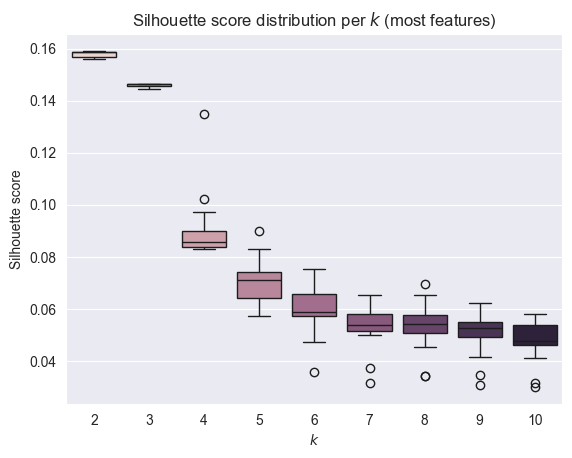

In [166]:
# See the silhouette score distribution per k
ax = sns.boxplot(df_results_all, x="k", y="ss", hue="k", legend=False)
ax.set_xlabel("$k$")
ax.set_ylabel("Silhouette score")
ax.set_title("Silhouette score distribution per $k$ (most features)");

It appears that $k=2$ is the ideal number of clusters again. Let's filter our
results and get a top 5 ranking of best seeds for $k=2$.

In [167]:
df_results_all[df_results_all["k"] == 2].sort_values(by="ss", ascending=False).head(5)

k     seed        ss
0   2   154405  0.159105
4   2  9090867  0.159105
12  2  4513921  0.159105
8   2  3336162  0.159105
18  2  8619079  0.159105

Again, not much variation for $k=2$, which is also clear by looking at the box
plot above.

Let's repeat clustering with $k=2$ for one of the top seeds, apply PCA and then
plot the two first principal components (PC1 and PC2).

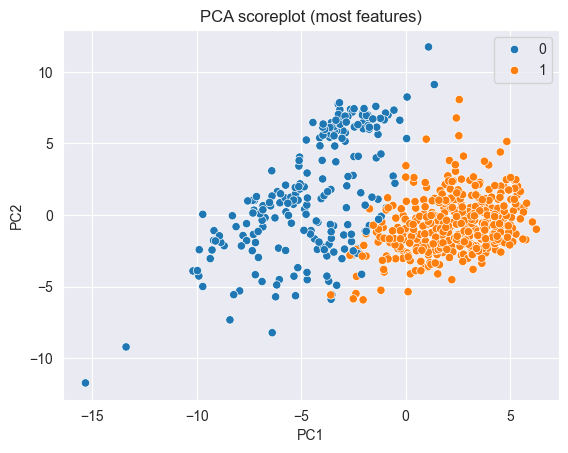

In [168]:
# Perform k-means with the top seed
km_all = KMeans(n_clusters=2, random_state=154405)
clust_labels_all = km_all.fit_predict(X_all_scaled)

# Apply PCA and get the first two principal components (PCs)
pca_all = PCA(n_components=2)
X_all_pca = pca_all.fit_transform(X_all_scaled)

# Display scatter plot of the first two PCs
ax = sns.scatterplot(x=X_pca_num[:,0], y=X_pca_num[:,1], hue=clust_labels_all)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA scoreplot (most features)");

The additional features don't appear to make much difference in terms of
clusters. Compare with the previous PCA score plot done above for the numerical
features only.

Let's put the scaled data into a dataframe so we can perform a few more
analysis (heatmap, etc).

In [169]:
# Put scaled data into a dataframe again
df_scaled_all = pd.DataFrame(
    X_all_scaled,
    # Use the original dataframe's column names
    columns=df_num_all.columns,
)

# Add the cluster labels (as found by k-Means) to the data frame...
df_scaled_all["cluster"] = clust_labels_all

# ...and take a look at it
df_scaled_all

C1        C2        C3        C4        C5        C6        C7  \
0    0.229238  0.011626  1.035355 -1.620426  0.776365 -0.146076 -0.351163   
1    0.229238 -0.918418  1.035355  2.192341  0.776365  0.798252  0.783910   
2    1.292373 -0.918418  1.035355  1.239149  0.776365  0.798252  0.783910   
3    0.229238  0.941670  1.035355  0.285958 -0.390005 -1.090403  0.783910   
4   -0.833896  0.941670 -1.265434 -1.620426  0.776365 -1.090403 -1.486236   
..        ...       ...       ...       ...       ...       ...       ...   
635 -0.833896 -0.918418 -1.265434 -0.667234 -0.390005 -0.146076 -0.351163   
636  0.229238  0.011626 -0.115039  0.285958  0.776365  0.798252 -0.351163   
637  0.229238  0.011626 -0.115039  0.285958 -0.390005 -0.146076 -0.351163   
638  0.229238  0.941670 -0.115039 -0.667234 -0.390005  1.742580 -2.621309   
639  0.229238  0.941670 -1.265434  2.192341 -2.722744 -0.146076  0.783910   

           C8        C9       C10  ...  A4_garden    A5_age  A7_relationship  \
0   -0.194407 -1.534704  0.217918  ...  -1.061247 -2.715532        -0.766870   
1    1.341647  0.855103  1.001444  ...   0.942287 -2.355934        -0.766870   
2    1.341647  0.855103  1.001444  ...   0.942287 -2.355934        -0.766870   
3    0.573620 -0.339801 -0.565608  ...  -1.061247 -2.355934        -0.766870   
4    0.573620  0.855103 -0.565608  ...  -1.061247 -2.176134        -0.766870   
..        ...       ...       ...  ...        ...       ...              ...   
635 -0.962434 -0.339801  0.217918  ...   0.942287  3.937044         1.304002   
636  0.573620 -0.339801  1.001444  ...  -1.061247  4.116844        -0.766870   
637 -0.194407  0.855103  1.001444  ...  -1.061247  5.195640         1.304002   
638 -0.194407 -0.339801  0.217918  ...   0.942287  1.599653         1.304002   
639  1.341647 -0.339801  0.217918  ...  -1.061247 -0.737739        -0.766870   

     B1_social_dist  B2_social_dist_days  B3_covid_worried  \
0          0.531569             0.719409          0.065198   
1          0.531569             0.719409          0.065198   
2          0.531569             0.719409         -1.238765   
3          0.531569             0.719409          0.065198   
4          0.531569            -0.315614         -1.238765   
..              ...                  ...               ...   
635        0.531569             0.719409          1.369161   
636        0.531569             0.719409          0.065198   
637        0.531569             0.719409          0.065198   
638        0.531569             0.719409         -1.238765   
639       -1.881225            -1.731961          0.065198   

     D1_years_playing_games  D3_play_frequency  D5_ac_frequency  cluster  
0                  0.443114           0.010902         0.666062        1  
1                  0.443114           0.786151        -0.272880        1  
2                  0.443114           0.786151        -0.272880        1  
3                  0.443114           0.786151         0.666062        1  
4                  0.443114           0.786151         0.666062        1  
..                      ...                ...              ...      ...  
635                0.443114           0.010902         0.666062        1  
636                0.443114           0.786151         0.666062        1  
637                0.443114           0.786151         0.666062        1  
638                0.443114          -0.764347        -0.272880        0  
639                0.443114           0.010902        -0.272880        1  

[640 rows x 89 columns]

In [170]:
# Let's get the mean of each feature per cluster
df_cluster_means_all = df_scaled_all.groupby("cluster").mean()

# A quick peek at the resulting dataframe
df_cluster_means_all

C1        C2        C3        C4        C5        C6        C7  \
cluster                                                                         
0       -0.031623 -0.492148 -0.296120 -0.292136 -0.595199  0.015684 -0.619167   
1        0.016110  0.250717  0.150854  0.148824  0.303215 -0.007990  0.315424   

               C8        C9       C10  ...    A4_pet  A4_garden    A5_age  \
cluster                                ...                                  
0       -0.706425 -0.455972 -0.834038  ...  0.039484   0.200238  0.267805   
1        0.359877  0.232288  0.424887  ... -0.020114  -0.102008 -0.136429   

         A7_relationship  B1_social_dist  B2_social_dist_days  \
cluster                                                         
0               0.383615       -0.283866            -0.597320   
1              -0.195426        0.144611             0.304295   

         B3_covid_worried  D1_years_playing_games  D3_play_frequency  \
cluster                                                                
0               -0.055539               -0.338696          -0.301351   
1                0.028294                0.172543           0.153518   

         D5_ac_frequency  
cluster                   
0              -0.768432  
1               0.391465  

[2 rows x 88 columns]

We can now plot a heapmap showing the feature means by cluster:

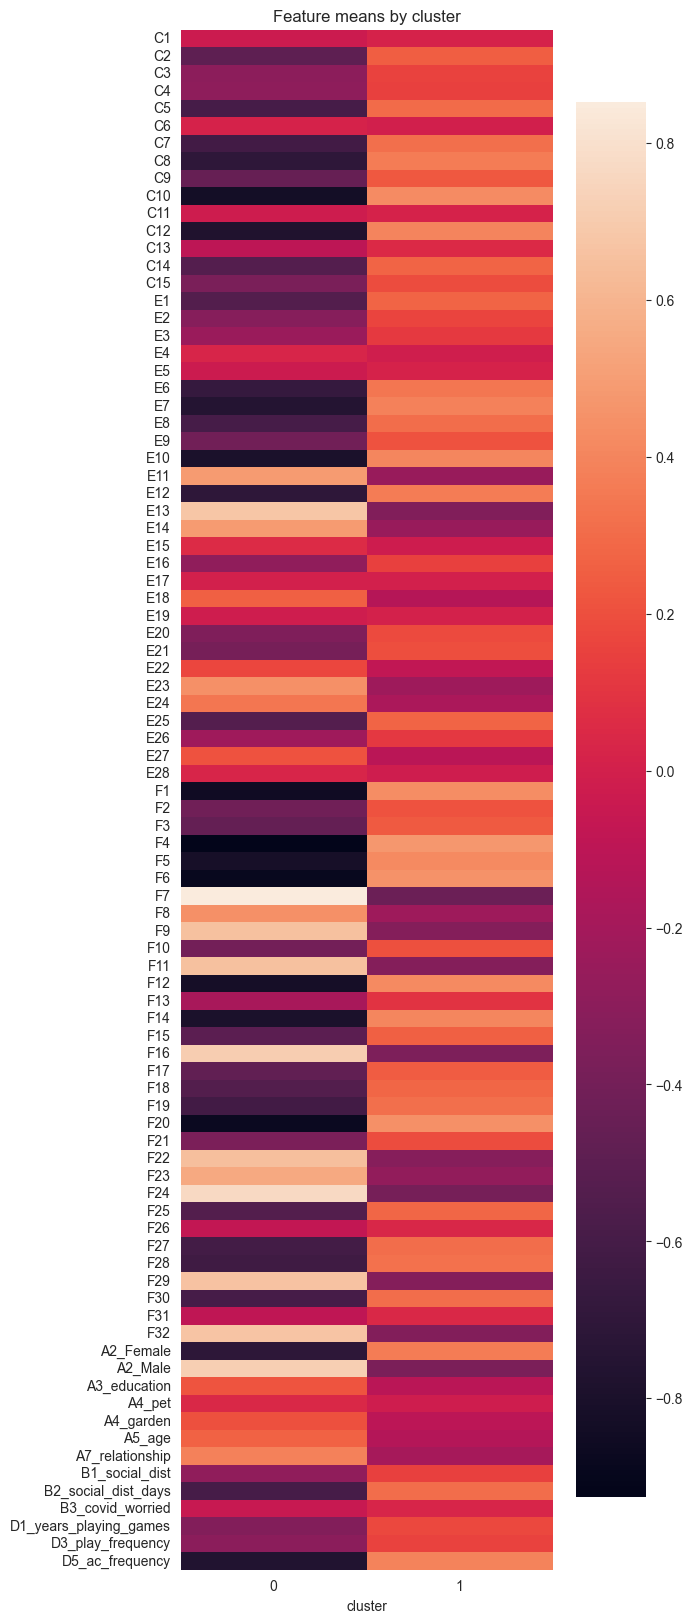

In [171]:
fig, ax = plt.subplots(figsize=(6, 20))
sns.heatmap(df_cluster_means_all.T, ax=ax)
ax.set_title("Feature means by cluster");


It's clear that many features are quite different in the two clusters. Let's see
which are more different:

In [172]:
# Will be useful to use the transposed version of our feature means dataframe
df_cluster_means_all_T = df_cluster_means_all.T

# Create a new dataframe containing the feature means and their differences,
# and then order the dataframe by these differences (largest to smallest)
df_cluster_diffs_all = pd.DataFrame(
    {
        "feature": df_cluster_means_all_T.index.to_numpy(),
        "mean_cluster_0": df_cluster_means_all_T[0].to_numpy(),
        "mean_cluster_1": df_cluster_means_all_T[1].to_numpy(),
        "means_diff": np.abs(
            df_cluster_means_all_T[0].to_numpy() - df_cluster_means_all_T[1].to_numpy()
        ),
    }
).sort_values(by="means_diff", ascending=False)

# Let's put a feature legend so we can better understand what we're looking at
df_cluster_diffs_all["feature_legend"] = (
    df_cluster_diffs_all["feature"]
    .str.split("_") # We need this for categorical features added after
    .str[0]
    .map(dict(zip(df_feat_info["Code"], df_feat_info["Question"])))
)

# Look at differences larger than 1.1
df_cluster_diffs_all[df_cluster_diffs_all["means_diff"] > 1.1]

feature  mean_cluster_0  mean_cluster_1  means_diff  \
46               F4       -0.926112        0.471793    1.397905   
48               F6       -0.885575        0.451142    1.336717   
62              F20       -0.874805        0.445655    1.320460   
49               F7        0.852006       -0.434041    1.286046   
43               F1       -0.851594        0.433831    1.285424   
9               C10       -0.834038        0.424887    1.258925   
54              F12       -0.823011        0.419270    1.242280   
47               F5       -0.818027        0.416731    1.234758   
24              E10       -0.798287        0.406674    1.204961   
56              F14       -0.797908        0.406481    1.204389   
11              C12       -0.773363        0.393977    1.167341   
87  D5_ac_frequency       -0.768432        0.391465    1.159898   
66              F24        0.762370       -0.388377    1.150747   
21               E7       -0.753956        0.384091    1.138046   

                                                                                                                             feature_legend  
46                                                                       In overall, how do you feel about the game? [I thought it was fun]  
48                                                                               In overall, how do you feel about the game? [I felt happy]  
62                                                                               In overall, how do you feel about the game? [I enjoyed it]  
49                                                                      In overall, how do you feel about the game? [It gave me a bad mood]  
43                                                                             In overall, how do you feel about the game? [I felt content]  
9   How much do you agree with the following statements? [The so-called “ecological crisis” facing humankind has been greatly exaggerated.]  
54                                                              In overall, how do you feel about the game? [It was aesthetically pleasing]  
47                                                         In overall, how do you feel about the game? [I was fully occupied with the game]  
24                                                   How often do you do the following activities with fish or bugs? [Donate to the museum]  
56                                                                                In overall, how do you feel about the game? [I felt good]  
11                                How much do you agree with the following statements? [Humans were meant to rule over the rest of nature.]  
87                                                                                                   How often do you play Animal Crossing?  
66                                                                           In overall, how do you feel about the game? [I felt irritable]  
21                                                             Do you want to collect or plant all the following species in the game? [Bug]

Most of these features correspond to very similar questions about how the player
feels about the game, and a related one about how often the player plays the
game. Two other features are related to in-game activities, namely:

- How often does the player donates fish or bugs to the museum.
- If the player wants to collect all bugs in the game.

However, two other influential features are quite different, and are related to
how much the player agrees with each of the following statements:

- *The so-called “ecological crisis” facing humankind has been greatly exaggerated.*
- *Humans were meant to rule over the rest of nature.*

Let's see how these features vary between clusters:

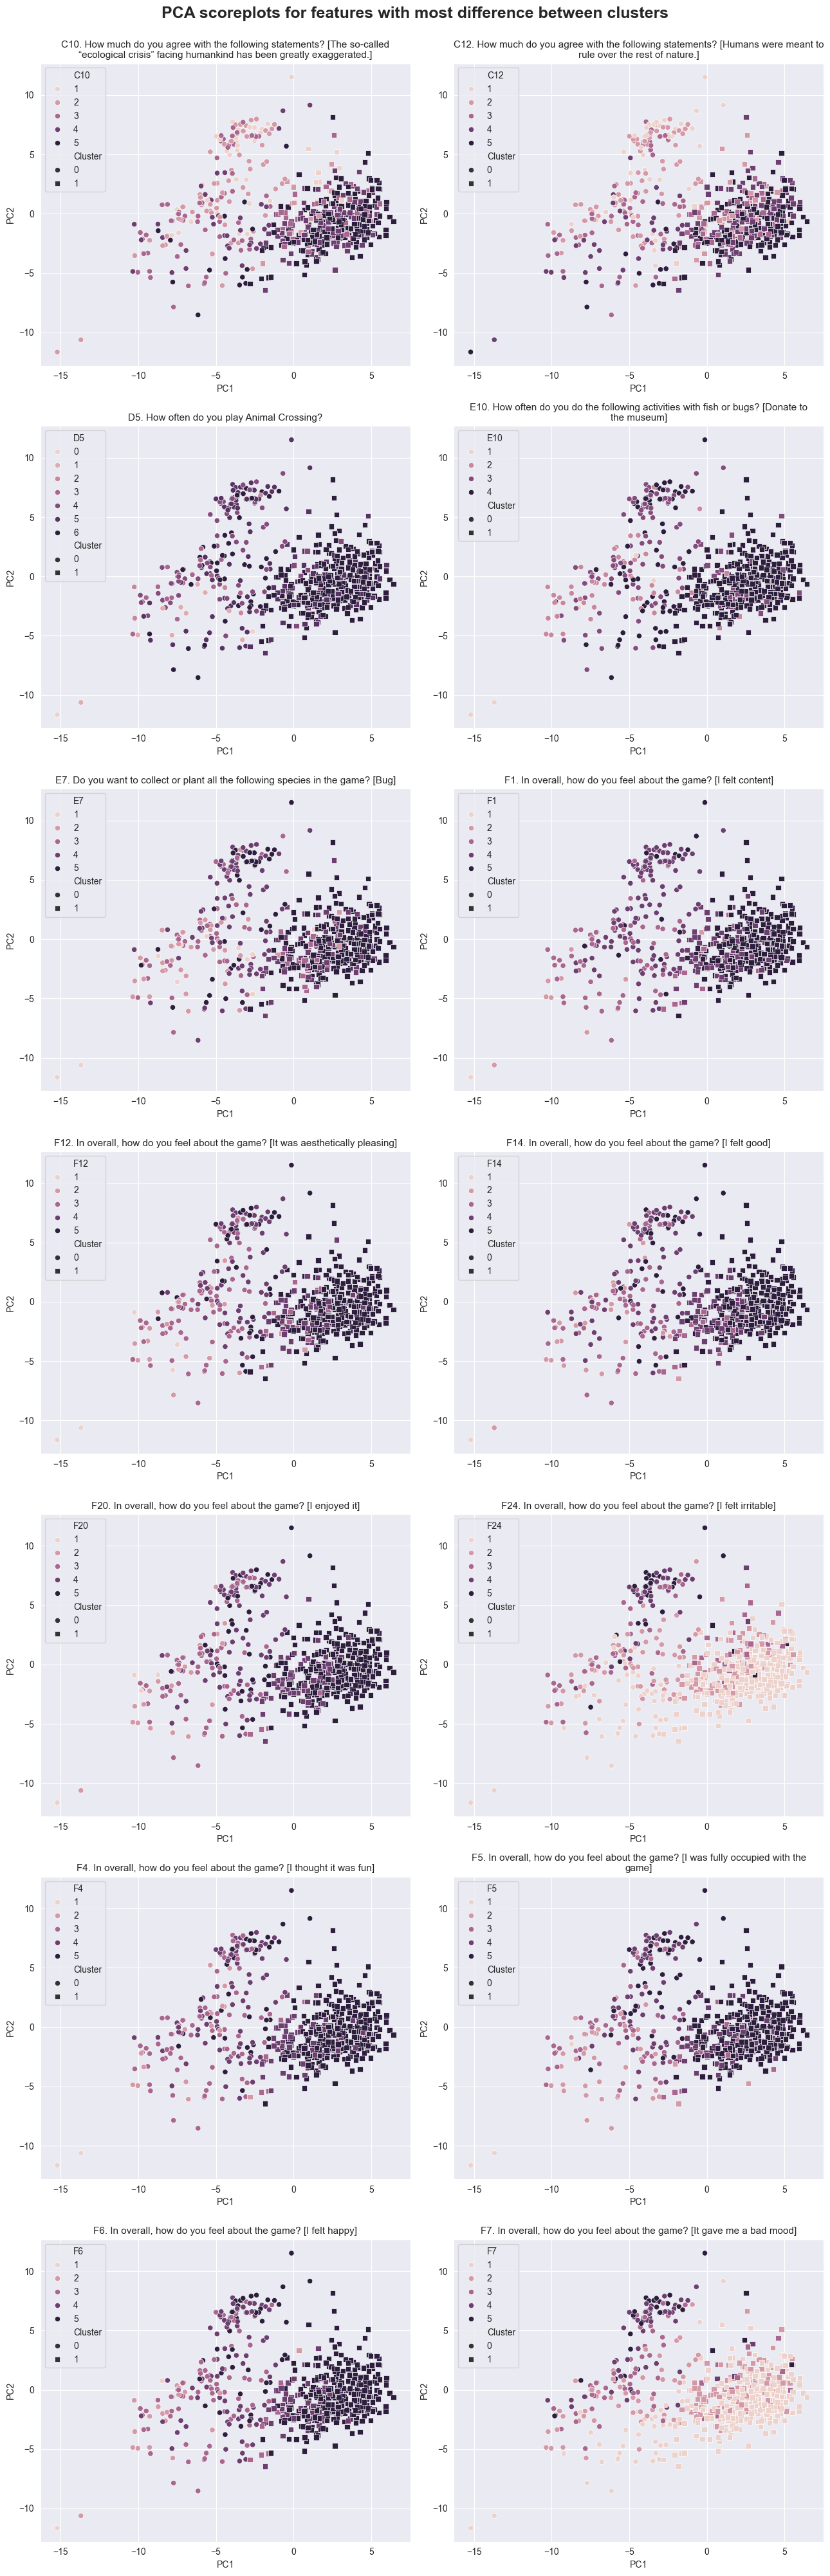

In [173]:
# Get the differences larger than 1.1, sort them by feature code
df_cmdiff_top_all = df_cluster_diffs_all[
    df_cluster_diffs_all["means_diff"] > 1.1
].sort_values(by="feature")

# Prepare the subplots
fig, ax = plt.subplots(7, 2, figsize=(13, 40))

# We'll use a dataframe for the plot, as it's better supported by Seaborn
df_to_plot_pca = pd.DataFrame(X_all_pca, columns=["PC1", "PC2"])
df_to_plot_pca["Cluster"] = clust_labels_all

# Loop through the features
for i, row in enumerate(df_cmdiff_top_all.iterrows()):

    # Select the subplot to draw on
    axc = ax[i // 2, i % 2]

    # Get feature name
    feature = row[1]["feature"].split("_")[0]

    # Add the current feature to the dataframe to plot
    df_to_plot_pca[feature] = df_num_all[row[1]["feature"]].to_numpy()

    # Draw the scatter plot for the first two PCs with hue (color) representing
    # the current feature values
    sns.scatterplot(
        df_to_plot_pca,
        x="PC1",
        y="PC2",
        hue=feature,
        style="Cluster",
        markers=["o", "s"],
        ax=axc,
    )

    # Set plot title
    plt_title = textwrap.fill(
        feature + ". " + row[1]["feature_legend"], width=80
    )
    axc.set_title(plt_title, fontsize=11)

# Nice top title
fig.suptitle(
    "PCA scoreplots for features with most difference between clusters",
    y=1.00,
    fontsize=18,
    fontweight="bold"
)

fig.tight_layout()

It is clear that the enjoyment of the game, as well as performing some of the
in-game activities, are associated with one of the two clusters. What is more
interesting is that people who enjoy the game don't appear to be very
environmentionally conscious. Cluster 1, composed of players who like the game
most, is also constituted by players who believe the "ecological crisis" is
greatly exaggerated (C10) and that humans are meant to rule over the rest of
nature (C12).

Let's see how $t$-SNE displays this same data, namely if the clusters are better
separated by it. We'll apply it directly to the data without PCA, since there
are not that many dimensions:

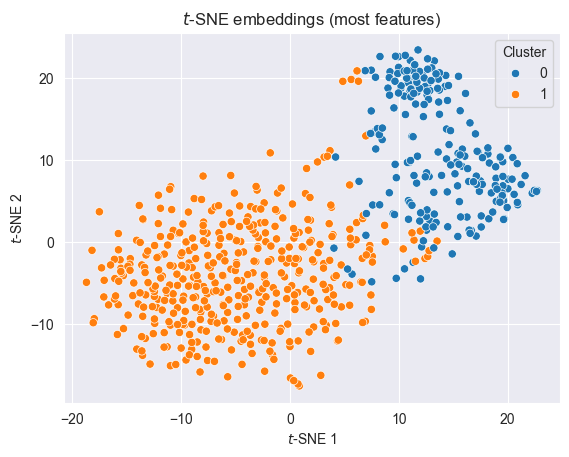

In [174]:
X_all_tsne = TSNE(random_state=42).fit_transform(X_all_scaled)
df_to_plot_tsne = pd.DataFrame(X_all_tsne, columns=["$t$-SNE 1", "$t$-SNE 2"])
df_to_plot_tsne["Cluster"] = clust_labels_all
ax = sns.scatterplot(df_to_plot_tsne, x="$t$-SNE 1", y="$t$-SNE 2", hue="Cluster")
ax.set_title("$t$-SNE embeddings (most features)");

Interestingly, the clusters appear somewhat more separated with $t$-SNE.
However, since $t$-SNE is stochastic, the embeddings may look worse with
different seeds. In any case, let's look at the features under $t$-SNE, as we
did for PCA:

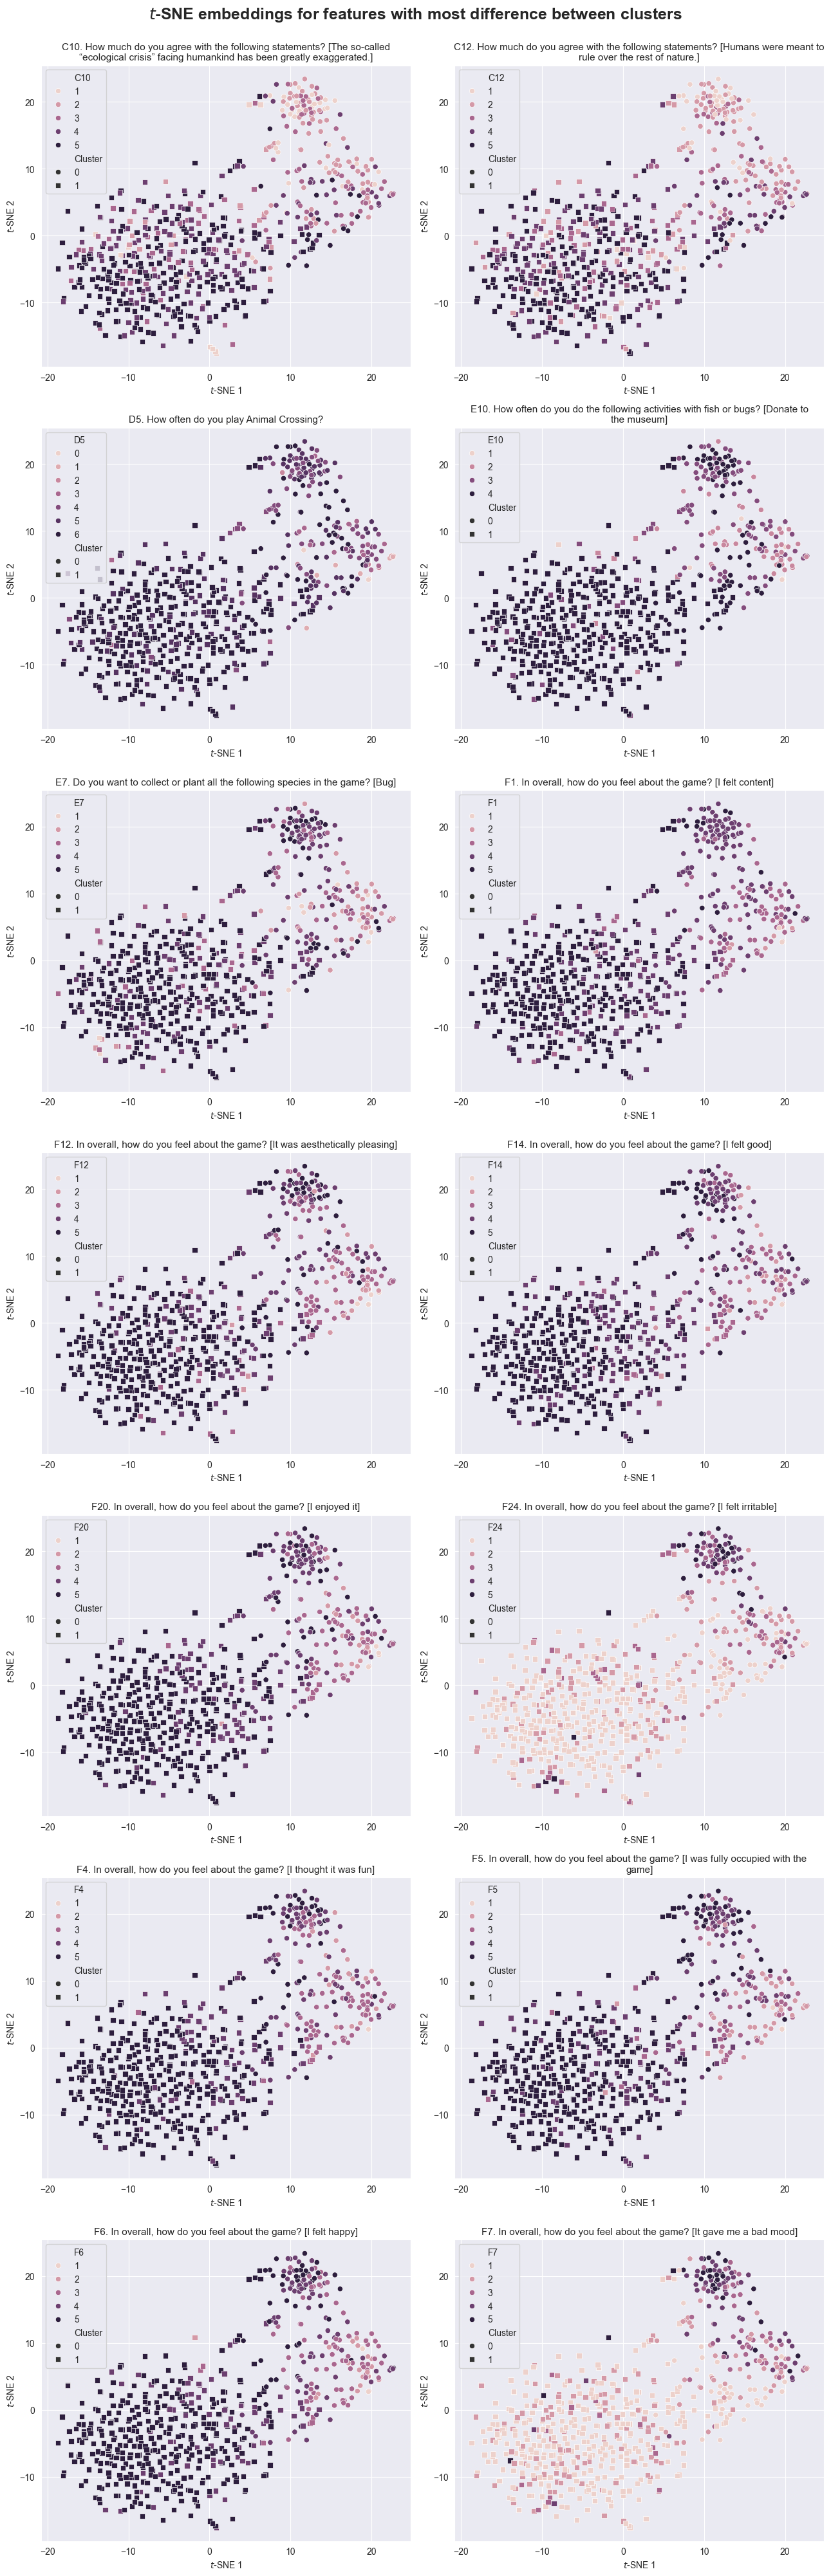

In [175]:
# Prepare the subplots
fig, ax = plt.subplots(7, 2, figsize=(13, 40))

# Loop through the features
for i, row in enumerate(df_cmdiff_top_all.iterrows()):

    # Select the subplot to draw on
    axc = ax[i // 2, i % 2]

    # Get feature name
    feature = row[1]["feature"].split("_")[0]

    # Add the current feature to the dataframe to plot
    df_to_plot_tsne[feature] = df_num_all[row[1]["feature"]].to_numpy()

    # Draw the scatter plot for the first two embeddings with hue (color)
    # representing the current feature values
    sns.scatterplot(
        df_to_plot_tsne,
        x="$t$-SNE 1",
        y="$t$-SNE 2",
        hue=feature,
        style="Cluster",
        markers=["o", "s"],
        ax=axc,
    )

    # Set plot title
    plt_title = textwrap.fill(
        feature + ". " + row[1]["feature_legend"], width=80
    )
    axc.set_title(plt_title, fontsize=11)

# Nice top title
fig.suptitle(
    "$t$-SNE embeddings for features with most difference between clusters",
    y=1.00,
    fontsize=18,
    fontweight="bold"
)

fig.tight_layout()

These plots confirm our previous findings, but hint further at a possible third
cluster.

In the next section, we'll perform PCA **before** clustering and see if anything
changes in our analysis.

### PCA before clustering (numeric + some categorical features)

Let's perform PCA and keep the first 20 PCs.

In [176]:
# Perform PCA
pca_pre_all = PCA(n_components=20)
X_all_scaled_pca_pre = pca_pre_all.fit_transform(X_all_scaled)

# Check how much variance is explained by the selected PCs
pca_pre_all.explained_variance_ratio_

array([0.181922  , 0.10920795, 0.03266805, 0.03178624, 0.02882349,
       0.02659626, 0.02242713, 0.01987661, 0.01948682, 0.01770914,
       0.0174564 , 0.0164775 , 0.01493859, 0.013951  , 0.01338718,
       0.01268771, 0.01209764, 0.01169367, 0.01138669, 0.01111178])

The first two PCs actually explain much of the variance (18% and 11%,
respectively), so let's perform clustering using only these two components.

In [177]:
# We'll put results in this list
clust_results_all_pca_pre = []

# Loop through k
for k in range(2,11):

    # Loop through seeds (we'll use the same seeds created for the previous experiments)
    for seed in seeds:

        # Perform k-means for the current k and seed combination
        km = KMeans(n_clusters=k, random_state=seed)
        clu_lbls = km.fit_predict(X_all_scaled_pca_pre[:, :2]) # most of the variance is in PC1 and PC2

        # Get the silhouette score and save it to the results list
        ss = silhouette_score(X_all_scaled_pca_pre[:, :2], clu_lbls)
        clust_results_all_pca_pre.append([k, seed, ss])

# Create the results data frame and show it
df_results_all_pca_pre = pd.DataFrame(clust_results_all_pca_pre, columns=["k", "seed", "ss"])

df_results_all_pca_pre

k     seed        ss
0     2   154405  0.503390
1     2  6823517  0.503390
2     2  5929477  0.503390
3     2   538210  0.503390
4     2  9090867  0.503390
..   ..      ...       ...
265  10  8242415  0.373661
266  10  7920811  0.349538
267  10  2137629  0.361533
268  10  4096017  0.371706
269  10  7414669  0.360931

[270 rows x 3 columns]

Text(0.5, 1.0, 'Silhouette score distribution per $k$ (most features, clustering after PCA)')

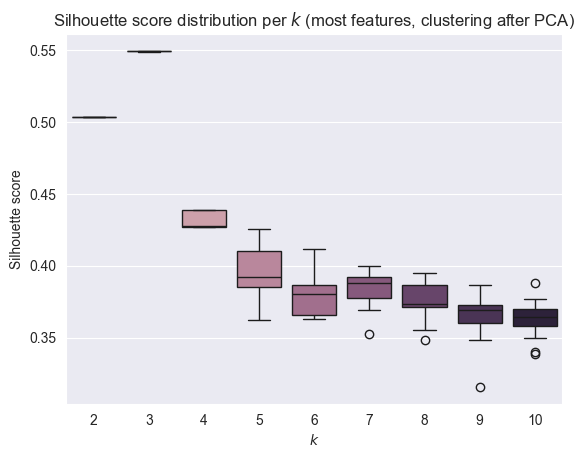

In [178]:
# See the silhouette score distribution per k
ax = sns.boxplot(df_results_all_pca_pre, x="k", y="ss", hue="k", legend=False)
ax.set_xlabel("$k$")
ax.set_ylabel("Silhouette score")
ax.set_title(
    "Silhouette score distribution per $k$ (most features, clustering after PCA)"
)

Two interesting things are visible in this plot:

- The ideal number of clusters, according to the silhouette score, is $k=3$.
- The overall silhouette scores are quite higher than what was observed
  previously, indicating that clusters might actually be better separated now.

Let's look at the top 5 seeds for $k=3$:

In [179]:
df_results_all_pca_pre[df_results_all_pca_pre["k"] == 3].sort_values(
    by="ss", ascending=False
).head(5)

k     seed        ss
30  3   154405  0.549606
31  3  6823517  0.549606
32  3  5929477  0.549606
34  3  9090867  0.549606
38  3  3336162  0.549606

Not much variation for $k=3$, which is also clear by looking at the box plot
above.

Let's repeat clustering with $k=3$ for one of the top seeds and then plot the
two first principal components (PC1 and PC2).

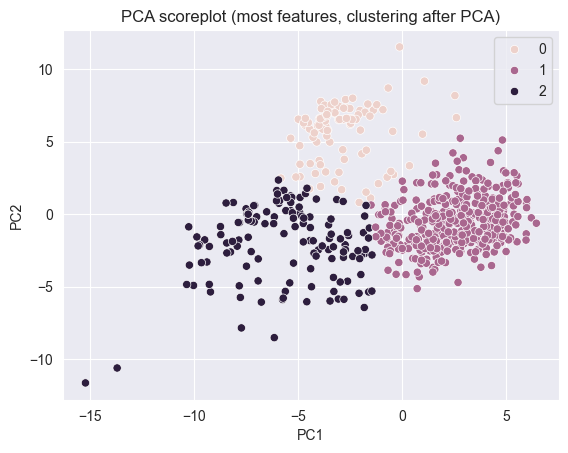

In [180]:
# Perform k-means with the top seed
km_all_pca_pre = KMeans(n_clusters=3, random_state=154405)
clust_labels_all_pca_pre = km_all_pca_pre.fit_predict(X_all_scaled_pca_pre)

# Display scatter plot of the first two PCs which were clustered
ax = sns.scatterplot(
    x=X_all_scaled_pca_pre[:, 0],
    y=X_all_scaled_pca_pre[:, 1],
    hue=clust_labels_all_pca_pre,
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("PCA scoreplot (most features, clustering after PCA)");

Visually, the three clusters are more or less perceptible.

Let's put the original scaled data (before PCA) into a dataframe so we can
perform a few more analysis (heatmap, etc). Note that the PCA'ed data does not
provide information on features, only on principal components. However, we'll
use the cluster labels obtained from clustering after PCA for this analysis.

In [181]:
# Put scaled data into a dataframe again
df_scaled_all_pca_pre = pd.DataFrame(
    X_all_scaled,
    # Use the original dataframe's column names
    columns=df_num_all.columns,
)

# Add the cluster labels (as found by k-Means) to the data frame...
df_scaled_all_pca_pre["cluster"] = clust_labels_all_pca_pre

# ...and take a look at it
df_scaled_all_pca_pre

C1        C2        C3        C4        C5        C6        C7  \
0    0.229238  0.011626  1.035355 -1.620426  0.776365 -0.146076 -0.351163   
1    0.229238 -0.918418  1.035355  2.192341  0.776365  0.798252  0.783910   
2    1.292373 -0.918418  1.035355  1.239149  0.776365  0.798252  0.783910   
3    0.229238  0.941670  1.035355  0.285958 -0.390005 -1.090403  0.783910   
4   -0.833896  0.941670 -1.265434 -1.620426  0.776365 -1.090403 -1.486236   
..        ...       ...       ...       ...       ...       ...       ...   
635 -0.833896 -0.918418 -1.265434 -0.667234 -0.390005 -0.146076 -0.351163   
636  0.229238  0.011626 -0.115039  0.285958  0.776365  0.798252 -0.351163   
637  0.229238  0.011626 -0.115039  0.285958 -0.390005 -0.146076 -0.351163   
638  0.229238  0.941670 -0.115039 -0.667234 -0.390005  1.742580 -2.621309   
639  0.229238  0.941670 -1.265434  2.192341 -2.722744 -0.146076  0.783910   

           C8        C9       C10  ...  A4_garden    A5_age  A7_relationship  \
0   -0.194407 -1.534704  0.217918  ...  -1.061247 -2.715532        -0.766870   
1    1.341647  0.855103  1.001444  ...   0.942287 -2.355934        -0.766870   
2    1.341647  0.855103  1.001444  ...   0.942287 -2.355934        -0.766870   
3    0.573620 -0.339801 -0.565608  ...  -1.061247 -2.355934        -0.766870   
4    0.573620  0.855103 -0.565608  ...  -1.061247 -2.176134        -0.766870   
..        ...       ...       ...  ...        ...       ...              ...   
635 -0.962434 -0.339801  0.217918  ...   0.942287  3.937044         1.304002   
636  0.573620 -0.339801  1.001444  ...  -1.061247  4.116844        -0.766870   
637 -0.194407  0.855103  1.001444  ...  -1.061247  5.195640         1.304002   
638 -0.194407 -0.339801  0.217918  ...   0.942287  1.599653         1.304002   
639  1.341647 -0.339801  0.217918  ...  -1.061247 -0.737739        -0.766870   

     B1_social_dist  B2_social_dist_days  B3_covid_worried  \
0          0.531569             0.719409          0.065198   
1          0.531569             0.719409          0.065198   
2          0.531569             0.719409         -1.238765   
3          0.531569             0.719409          0.065198   
4          0.531569            -0.315614         -1.238765   
..              ...                  ...               ...   
635        0.531569             0.719409          1.369161   
636        0.531569             0.719409          0.065198   
637        0.531569             0.719409          0.065198   
638        0.531569             0.719409         -1.238765   
639       -1.881225            -1.731961          0.065198   

     D1_years_playing_games  D3_play_frequency  D5_ac_frequency  cluster  
0                  0.443114           0.010902         0.666062        1  
1                  0.443114           0.786151        -0.272880        1  
2                  0.443114           0.786151        -0.272880        1  
3                  0.443114           0.786151         0.666062        1  
4                  0.443114           0.786151         0.666062        1  
..                      ...                ...              ...      ...  
635                0.443114           0.010902         0.666062        2  
636                0.443114           0.786151         0.666062        1  
637                0.443114           0.786151         0.666062        1  
638                0.443114          -0.764347        -0.272880        2  
639                0.443114           0.010902        -0.272880        2  

[640 rows x 89 columns]

In [182]:
# Let's get the mean of each feature per cluster
df_scaled_pca_pre_means_all = df_scaled_all_pca_pre.groupby("cluster").mean()

# A quick peek at the resulting dataframe
df_scaled_pca_pre_means_all

C1        C2        C3        C4        C5        C6        C7  \
cluster                                                                         
0        0.489367 -1.096512  0.264346 -0.778778 -0.439638 -0.316858 -0.182110   
1        0.004596  0.265274  0.159133  0.154806  0.317841 -0.020784  0.312590   
2       -0.344395 -0.035211 -0.644718  0.073375 -0.633348  0.275135 -0.792127   

               C8        C9       C10  ...    A4_pet  A4_garden    A5_age  \
cluster                                ...                                  
0       -1.117673 -0.047431 -1.215767  ...  0.435794   0.558632  0.497903   
1        0.350949  0.244440  0.425832  ... -0.027084  -0.111168 -0.153723   
2       -0.271762 -0.683658 -0.424686  ... -0.215405  -0.052273  0.113397   

         A7_relationship  B1_social_dist  B2_social_dist_days  \
cluster                                                         
0               0.731208        0.249220            -0.403701   
1              -0.196998        0.140305             0.299136   
2               0.082337       -0.579358            -0.602881   

         B3_covid_worried  D1_years_playing_games  D3_play_frequency  \
cluster                                                                
0                0.301021                0.013516          -0.022087   
1                0.020344                0.163497           0.146142   
2               -0.263138               -0.487868          -0.412975   

         D5_ac_frequency  
cluster                   
0              -0.362779  
1               0.393838  
2              -0.907847  

[3 rows x 88 columns]

We can now plot a heapmap showing the feature means by cluster:

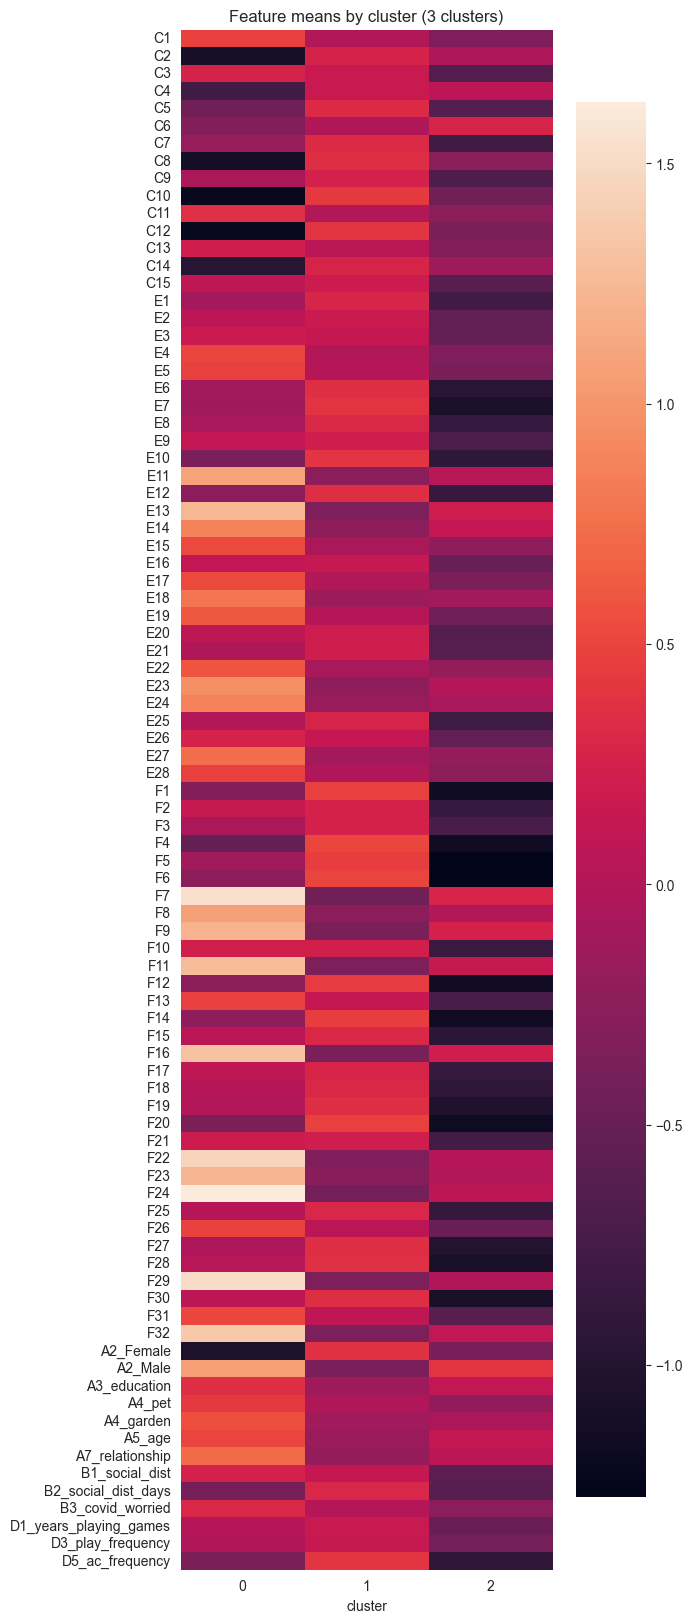

In [183]:
fig, ax = plt.subplots(figsize=(6, 20))
sns.heatmap(df_scaled_pca_pre_means_all.T, ax=ax)
ax.set_title("Feature means by cluster (3 clusters)");

There are features that are quite different between the three clusters. Let's
obtain the average three-way difference between feature means:

In [184]:
# Will be useful to use the transposed version of our feature means dataframe
df_scaled_pca_pre_means_all_T = df_scaled_pca_pre_means_all.T

# Create a new dataframe containing the feature means and their differences,
# and then order the dataframe by these differences (largest to smallest)
df_cluster_diffs_pca_pre_all = pd.DataFrame(
    {
        "feature": df_scaled_pca_pre_means_all_T.index.to_numpy(),
        "mean_cluster_0": df_scaled_pca_pre_means_all_T[0].to_numpy(),
        "mean_cluster_1": df_scaled_pca_pre_means_all_T[1].to_numpy(),
        "mean_cluster_2": df_scaled_pca_pre_means_all_T[2].to_numpy(),
        "means_diff": (
            np.abs(
                df_scaled_pca_pre_means_all_T[0].to_numpy()
                - df_scaled_pca_pre_means_all_T[1].to_numpy()
            )
            + np.abs(
                df_scaled_pca_pre_means_all_T[0].to_numpy()
                - df_scaled_pca_pre_means_all_T[2].to_numpy()
            )
            + np.abs(
                df_scaled_pca_pre_means_all_T[1].to_numpy()
                - df_scaled_pca_pre_means_all_T[2].to_numpy()
            )
        )
        / 3,  # We summed three differences, now divide by 3 to get the average
    }
).sort_values(by="means_diff", ascending=False)

# Let's put a feature legend so we can better understand what we're looking at
df_cluster_diffs_pca_pre_all["feature_legend"] = (
    df_cluster_diffs_pca_pre_all["feature"]
    .str.split("_") # We need this for categorical features added after
    .str[0]
    .map(dict(zip(df_feat_info["Code"], df_feat_info["Question"])))
)

# Look at average differences for the top 14 (to be the same number we used
# previously)
df_cluster_diffs_pca_pre_all.head(14)

feature  mean_cluster_0  mean_cluster_1  mean_cluster_2  means_diff  \
66     F24        1.627298       -0.402391        0.077749    1.353126   
49      F7        1.530785       -0.445817        0.270171    1.317735   
71     F29        1.507270       -0.345932       -0.006396    1.235468   
64     F22        1.451855       -0.338934        0.010588    1.193859   
48      F6       -0.263392        0.496161       -1.274668    1.180553   
47      F5       -0.116535        0.459412       -1.266377    1.150526   
74     F32        1.359528       -0.347358        0.097691    1.137924   
58     F16        1.310680       -0.377701        0.219573    1.125587   
46      F4       -0.521837        0.511725       -1.145464    1.104793   
62     F20       -0.356613        0.480440       -1.165594    1.097356   
43      F1       -0.315407        0.472829       -1.171174    1.096002   
9      C10       -1.215767        0.425832       -0.424686    1.094399   
53     F11        1.273055       -0.345185        0.149807    1.078827   
11     C12       -1.214334        0.402248       -0.356601    1.077722   

                                                                                                                             feature_legend  
66                                                                           In overall, how do you feel about the game? [I felt irritable]  
49                                                                      In overall, how do you feel about the game? [It gave me a bad mood]  
71                                                                          In overall, how do you feel about the game? [I felt frustrated]  
64                                                                             In overall, how do you feel about the game? [I felt annoyed]  
48                                                                               In overall, how do you feel about the game? [I felt happy]  
47                                                         In overall, how do you feel about the game? [I was fully occupied with the game]  
74                                                                       In overall, how do you feel about the game? [I felt time pressure]  
58                                                                               In overall, how do you feel about the game? [I felt bored]  
46                                                                       In overall, how do you feel about the game? [I thought it was fun]  
62                                                                               In overall, how do you feel about the game? [I enjoyed it]  
43                                                                             In overall, how do you feel about the game? [I felt content]  
9   How much do you agree with the following statements? [The so-called “ecological crisis” facing humankind has been greatly exaggerated.]  
53                                                                      In overall, how do you feel about the game? [I thought it was hard]  
11                                How much do you agree with the following statements? [Humans were meant to rule over the rest of nature.]

Looking at these results, we can conclude on the type of players in each
cluster:

- Cluster 0:
  - Very strong negative feelings elicited by the game (F24, F7, F29, F22, F32, F16).
  - Neutral positive feelings elicited by the game (F6, F4, F20, F1).
  - Very strong environmental and nature awareness (C10, C12).
- Cluster 1:
  - Weak negative feelings elicited by the game (F24, F7, F29, F22, F32, F16).
  - Moderate positive feelings elicited by the game (F6, F4, F20, F1).
  - Weak or even no environmental and nature awareness (C10, C12).
- Cluster 2:
  - Neutral negative feelings elicited by the game (F24, F7, F29, F22, F32, F16).
  - No positive feelings elicited by the game (F6, F4, F20, F1).
  - Moderate environmental and nature awareness (C10, C12).  

Using this information, let's aggregate these feature into three groups, and
plot the PCA score plots according to this grouping:

- Negative feelings: F24, F7, F29, F22, F32, F16
- Positive feelings: F6, F4, F20, F1
- Environmental awareness: C10, C12

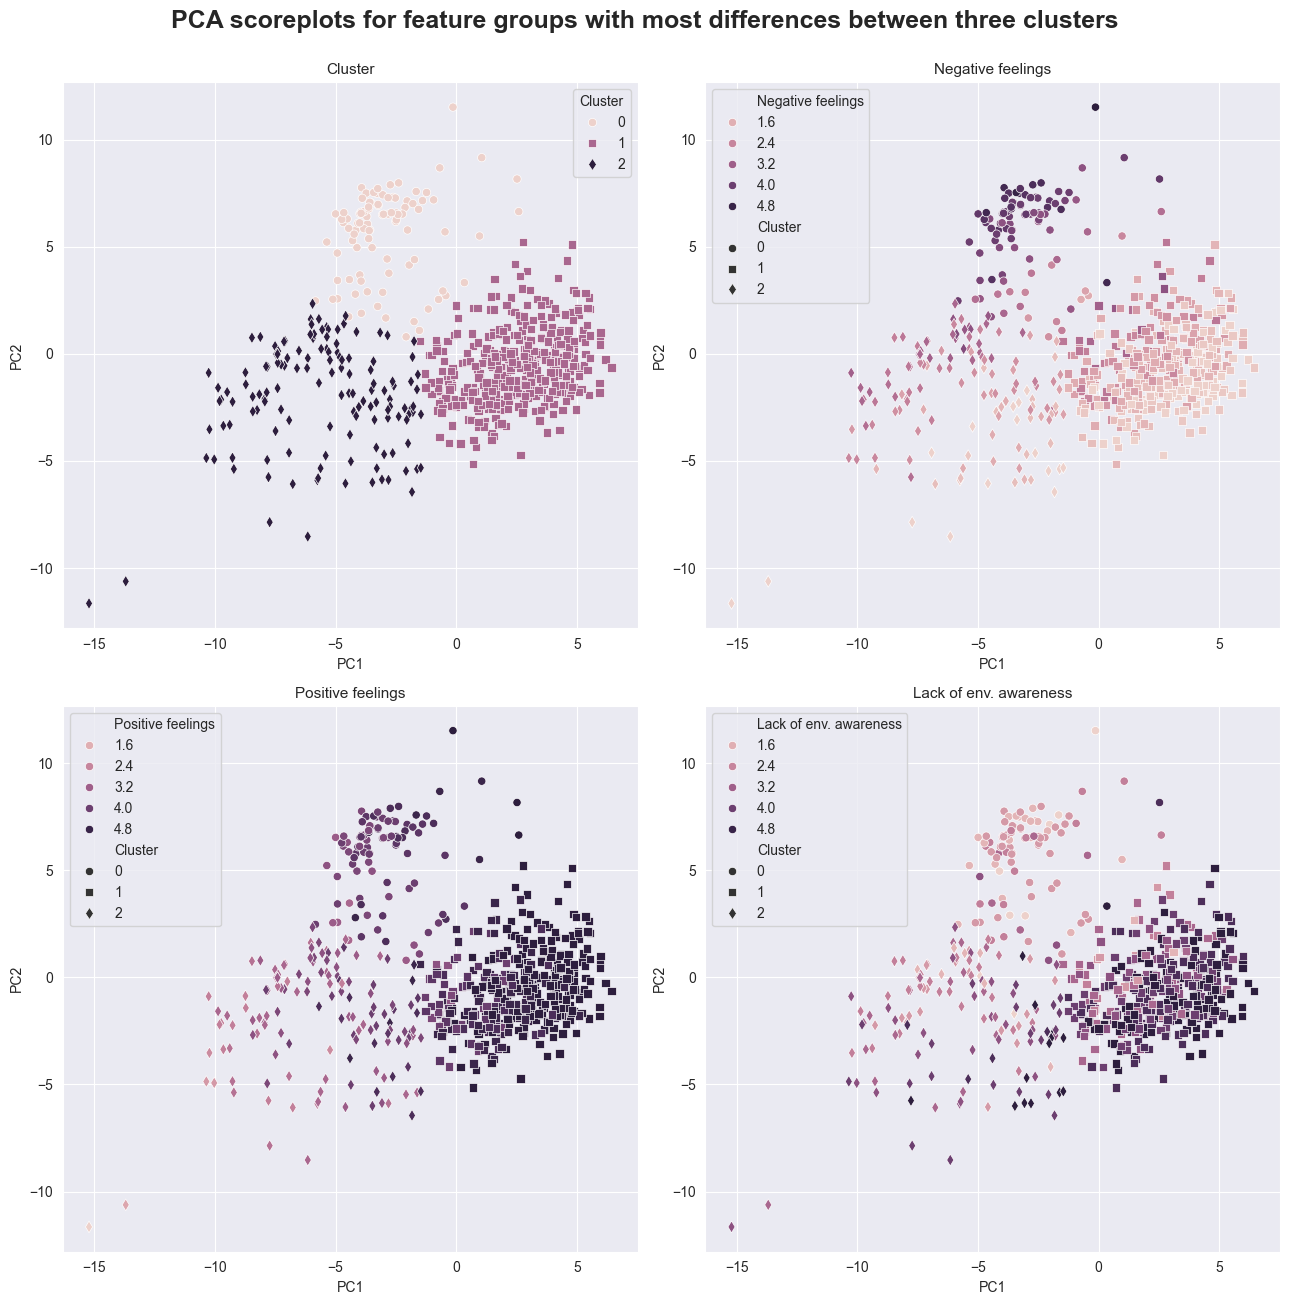

In [185]:
# Feature groups
feature_groups = {
    "Negative feelings" : ["F24", "F7", "F29", "F22", "F32", "F16"],
    "Positive feelings" : ["F6", "F4", "F20", "F1"],
    "Lack of env. awareness" : ["C10", "C12"],
}

# Prepare the subplots (clusters + the three feature groups)
fig, ax = plt.subplots(2, 2, figsize=(13, 13))

# We'll use a dataframe for the plot, as it's better supported by Seaborn
df_to_plot_pca_pre_fg = pd.DataFrame(X_all_scaled_pca_pre[:,:2], columns=["PC1", "PC2"])
df_to_plot_pca_pre_fg["Cluster"] = clust_labels_all_pca_pre

# Add the feature group means to the dataframe to plot
for fg in feature_groups:
    df_to_plot_pca_pre_fg[fg] = df_num_all[feature_groups[fg]].mean(axis=1).to_numpy()

# Loop through the items to plot
for i, cfg in enumerate(["Cluster"] + list(feature_groups.keys())):

    # Select the subplot to draw on
    axc = ax[i // 2, i % 2]

    # Draw the scatter plot for the first two PCs with hue (color) representing
    # the current feature values
    sns.scatterplot(
        df_to_plot_pca_pre_fg,
        x="PC1",
        y="PC2",
        hue=cfg,
        style="Cluster",
        markers=["o", "s", "d"],
        ax=axc,
    )

    # Set plot title
    axc.set_title(cfg, fontsize=11)

# Nice top title
fig.suptitle(
    "PCA scoreplots for feature groups with most differences between three clusters",
    y=1.00,
    fontsize=18,
    fontweight="bold",
)

fig.tight_layout()

These plots further underline our observations in the previous text block.
For completeness, the following plots show the 14 most influential features
separately.

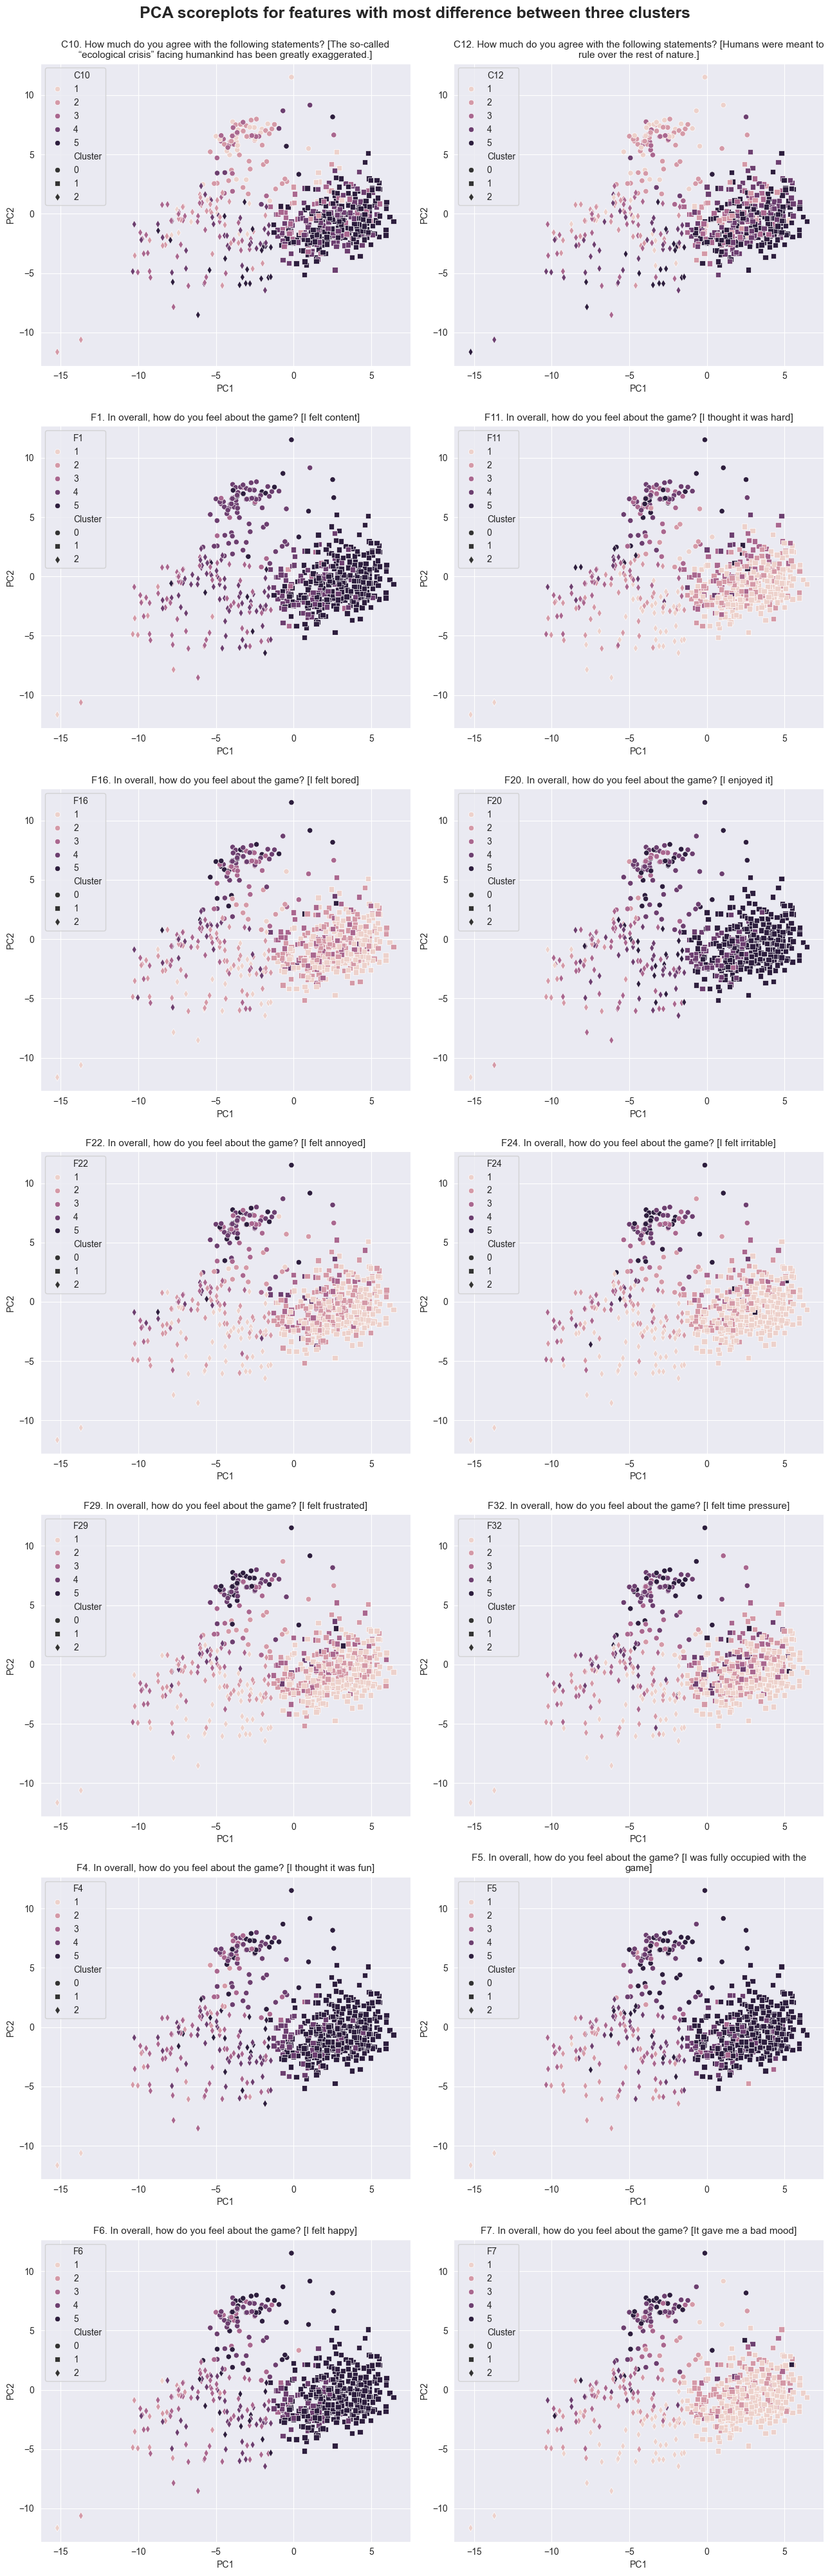

In [186]:
# Get the differences larger than 1.0, sort them by feature code
df_cmdiff_pca_pre_top_all = df_cluster_diffs_pca_pre_all.head(14).sort_values(
    by="feature"
)

# Prepare the subplots (we'll draw the top 14 again)
fig, ax = plt.subplots(7, 2, figsize=(13, 40))

# We'll use a dataframe for the plot, as it's better supported by Seaborn
df_to_plot_pca_pre = pd.DataFrame(X_all_scaled_pca_pre[:,:2], columns=["PC1", "PC2"])
df_to_plot_pca_pre["Cluster"] = clust_labels_all_pca_pre

# Loop through the features
for i, row in enumerate(df_cmdiff_pca_pre_top_all.iterrows()):

    # Select the subplot to draw on
    axc = ax[i // 2, i % 2]

    # Get feature name
    feature = row[1]["feature"].split("_")[0]

    # Add the current feature to the dataframe to plot
    df_to_plot_pca_pre[feature] = df_num_all[row[1]["feature"]].to_numpy()

    # Draw the scatter plot for the first two PCs with hue (color) representing
    # the current feature values
    sns.scatterplot(
        df_to_plot_pca_pre,
        x="PC1",
        y="PC2",
        hue=feature,
        style="Cluster",
        markers=["o", "s", "d"],
        ax=axc,
    )

    # Set plot title
    plt_title = textwrap.fill(feature + ". " + row[1]["feature_legend"], width=80)
    axc.set_title(plt_title, fontsize=11)

# Nice top title
fig.suptitle(
    "PCA scoreplots for features with most difference between three clusters",
    y=1.00,
    fontsize=18,
    fontweight="bold",
)

fig.tight_layout()